- name: dataAna.ipynb
- date: Nov. 21, 2024
- contact: JiaoWu2020@gmail.com
- environment: Python 3.11.9

## Environment preparation

In [1]:
# import packages
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.linear_model import LinearRegression as lm
from scipy import stats
import math
import random as rnd
import warnings

In [2]:
# get the working directories
codeDir = os.getcwd()
rootDir = os.path.abspath(os.path.join(codeDir, '..'))
oriDataDir = os.path.join(rootDir, '../seq_follow_pilot/data')
dataDir = os.path.join(rootDir, 'data')
figsDir = os.path.join(rootDir, 'figures')
statDir = os.path.join(rootDir, 'stats')

# set parameters
sns.set_context("notebook", font_scale=1.25)

# ignore warnings in pandas
pd.options.mode.chained_assignment = None # default='warn'

In [151]:
# define function for multiple linear regression
def LM_2F(data, factors):
    parList = data.nPar.unique()
    nPar = parList.size
    slope_f1 = np.zeros(nPar)
    slope_f2 = np.zeros(nPar)
    intercept = np.zeros(nPar)
    for i in range(nPar):
        iPar = parList[i]
        tmp = data.query('nPar == @iPar')
        reg = lm().fit(tmp[[factors[0],factors[1]]], tmp[factors[2]])
        slope_f1[i-1] = reg.coef_[0]
        slope_f2[i-1] = reg.coef_[1]
        intercept[i-1] = reg.intercept_ 
    return slope_f1, slope_f2, intercept

# define function for simple linear regression
def LM_1F(data,factors):
    parList = data.nPar.unique()
    nPar = parList.size
    slope = np.zeros(nPar)
    intercept = np.zeros(nPar)
    for i in range(nPar):
        iPar = parList[i]
        tmp = data.query('nPar == @iPar')
        reg = lm().fit(tmp[[factors[0]]], tmp[factors[1]])
        slope[i] = reg.coef_[0]
        intercept[i] = reg.intercept_ 
    return slope, intercept

def LMnF_mrg_nBack(data, colList):
    parList = data.nPar.unique()
    nPar = parList.size
    slope_cti = np.zeros(nPar)
    slope_sdi = np.zeros(nPar)
    intercept = np.zeros(nPar)
    for i in range(nPar):
        iPar = parList[i]
        tmp = data.query('nPar == @iPar')
        reg = lm().fit(tmp[['curDur']+colList], tmp['curBias'])
        slope_cti[i-1] = reg.coef_[0]
        slope_sdi[i-1] = reg.coef_[len(colList)]
        intercept[i-1] = reg.intercept_ 
    return slope_sdi

def LMnF_nBack(data, colName):
    parList = data.nPar.unique()
    nPar = parList.size
    slope_sdi = np.zeros(nPar)
    intercept = np.zeros(nPar)
    for i in range(nPar):
        iPar = parList[i]
        tmp = data.query('nPar == @iPar')
        reg = lm().fit(tmp[['curDur']+colName], tmp['curBias'])
        slope_sdi[i-1] = reg.coef_[1]
        intercept[i-1] = reg.intercept_ 
    return slope_sdi

# define function to do repeated measures ANOVA with Greenhouse-Geisser corrections
# provided long-format data
def rmANOVA_gg_Long(data, dv, within, subject):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        if len(within) == 1:
            GGpass = pg.sphericity(data, dv=dv, subject=subject, within=within, method='greenhouse-geisser')[0]
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction= not GGpass)
            if not GGpass:
                aov['DF-GG-corr'] = aov['DF'] * aov['eps'][0]
                aov.drop(columns=['sphericity', 'W-spher', 'p-spher'], inplace=True)
                print('* The assumption of sphericity is violated for factor:', within)
            return aov
        elif len(within) == 2:
            GGpass = pd.Series([True,True,True])
            factorDict = {"0":within[0], "1":within[1], "2":within}
            for i in range(3):
                GGpass[i] = pg.sphericity(data, dv=dv, subject=subject, within=factorDict[str(i)], method='greenhouse-geisser')[0]
                if not GGpass[i]:
                    print('* The assumption of sphericity is violated for factor:', factorDict[str(i)])
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction=True)
            eps = pd.Series([1,1,1])
            GGcrr = [not x for x in GGpass]
            eps[GGcrr] = aov['eps'][GGcrr]
            aov['DF1-GGcrr'] = aov['ddof1'] * eps
            aov['DF2-GGcrr'] = aov['ddof2'] * eps
            return aov


## Data loading and preparation

In [314]:
# get the list of data files
csv_files = glob.glob(os.path.join(oriDataDir, "seq_tasks_v2023_s*.csv"))
data = pd.DataFrame()

# read files and transform data
for i in range(len(csv_files)):
    parCSV = pd.read_csv(csv_files[i])

    # get useful columns
    df = parCSV.rename(columns = {'participant':'nPar', 'trials.thisRepN':'nB',\
            'trials.thisTrialN':'nT', 'duration':'curDur','cue':'curTask',\
            'rpr_duration':'rpr','follow_stimuli':'curflwDur','follow_production':'flw',\
            'follow_grating.started':'flwStimOn','follow_grating.stopped':'flwStimOff',\
            'follow_key_onset':'flwRspOn',\
            'reproduced_grating.started':'rprStimOn','rpr_onset':'rprRspOn'})
    df = df[['nPar','nB','nT','curDur','curTask','rpr','curflwDur','flw','flwStimOn','flwStimOff','flwRspOn','rprStimOn','rprRspOn']] # select columns

    # data transformation
    df = df.query('nB>0 & nPar.notnull()') # remove practice and rows with missing values
    df.nT = df.nT + 1 # convert nT to start from 1
    df['nT'] = df['nT'].astype(int) # convert nT to integer
    df['nB'] = df['nB'].astype(int) # convert nB to integer
    df['curflwDur'] = df['curflwDur'].round(1)
    df['nPar'] = df['nPar'].apply(lambda x: x[1:] if isinstance(x, str) else x)
    df['nPar'] = df['nPar'].astype(int)
    # exchange 'curDur' with 'curflwDur' in following condition, 
    # making 'curDur' to be the duration that observers made responses
    df.loc[df['curTask']=='following','curPreCueDur'] = df['curDur']
    df.loc[df['curTask']=='following','curDur'] = df['curflwDur']
    # add columns for follow onset and offset
    df['flwOnLtc'] = df['flwRspOn'] - df['flwStimOn']
    df['flwOffLtc'] = df['flwRspOn'] + df['flw'] - df['flwStimOff']
    df['flwAfterOff'] = df['flwRspOn'] > df['flwStimOff']
    # df['rprOnLtc'] = df['rprRspOn'] - df['rprStimOn']
    # add columns for previous task, duration, and report (trial n-1)
    df['preTask'] = df['curTask'].shift(periods=1)
    df.loc[df['nT']==1, ['preTask']] = pd.NA
    df['preDur'] = df['curDur'].shift(periods=1)
    df.loc[df['nT']==1, ['preDur']] = pd.NA
    df.loc[df['curTask']=='reproduction', 'curRpt'] = df['rpr']
    df.loc[df['curTask']=='following', 'curRpt'] = df['flw']
    df['preRpt'] = df['curRpt'].shift(periods=1)
    df.loc[df['nT']==1, ['preRpt']] = pd.NA
    df['prePreCueDur'] = df['curPreCueDur'].shift(periods=1)
    df.loc[df['nT']==1, ['prePCDur']] = pd.NA
    # select columns
    df = df[['nPar','nB','nT','curTask','curDur','rpr','flw','curPreCueDur','curRpt','preTask','preDur','preRpt','prePreCueDur','flwOnLtc','flwOffLtc', 'flwAfterOff']] # ,'rprOnLtc'
    # append the data
    data = pd.concat([data, df], ignore_index=True)

data.to_csv(os.path.join(dataDir, 'data_ori.csv'), index=False)

In [315]:
# data cleaning
data = pd.read_csv(dataDir + '/data_ori.csv')

# 1. get the distribution and Q-Q plot for reproduction (rpr) and follow (flw) responses
print('rpr range:[',data.query('rpr>0')['rpr'].min(),',',data.query('rpr>0')['rpr'].max(),']')
# data.query('rpr>0')['rpr'].hist(bins=20, color='grey', edgecolor='black') # & rpr < 0.9 & 
# plt.show()
# stats.probplot(df.query('rpr>0')['rpr'], dist="norm", plot=plt)
# plt.title("Q-Q Plot (rpr)")
# plt.show()

print('flw range:[',data.query('flw>0')['flw'].min(),',',data.query('flw>0')['flw'].max(),']')
# data.query('flw>0')['flw'].hist(bins=20, color='grey', edgecolor='black') # & flw<0.9
# plt.show()
# stats.probplot(df.query('flw>0')['flw'], dist="norm", plot=plt)
# plt.title("Q-Q Plot (flw)")
# plt.show()

# 2. remove outliers
data['valid'] = 1 # no outliers in rpr and flw for current pilot data
data.loc[data.query('(rpr>0 & rpr<0.2) | rpr>3 | (flw>0 & flw<0.2)').index,'valid'] = 0 # 
print('rpr valid:[',data.query('valid==1 & rpr>0')['rpr'].min(),',',data.query('valid==1 & rpr>0')['rpr'].max(),']')
print('flw valid:[',data.query('valid==1 & flw>0')['flw'].min(),',',data.query('valid==1 & flw>0')['flw'].max(),']')

# 3. save the cleaned data
data.to_csv(os.path.join(dataDir, 'dataAll.csv'), index=False)

rpr range:[ 0.0353018000005249 , 7.021174099998461 ]
flw range:[ 0.0704947999997784 , 3.034358900000143 ]
rpr valid:[ 0.2004183000026387 , 2.493399699999827 ]
flw valid:[ 0.2234513000003062 , 3.034358900000143 ]


In [316]:
# import data
data = pd.read_csv(dataDir + '/dataAll.csv')
dataValid = data.query('valid == 1') #  & nPar != 1

# get parameters
nPar = len(dataValid.nPar.unique())
print('Number of participants: ' + str(nPar))

# get dataframe for current and previous trial analyses
dataRpr = dataValid.query('curTask == "reproduction"')
dataRpr['curBias'] = dataRpr['rpr'] - dataRpr['curDur']

# # calculate deviation index ('deviat') for each participant
# mRprDurPar = dataRpr.groupby(['nPar', 'curDur']).rpr.mean().reset_index()
# mRprDurPar.columns = ['nPar', 'curDur','mRpr_Dur']
# dataRpr = pd.merge(dataRpr, mRprDurPar, on=['nPar','curDur'], how='left')
# dataRpr['deviat'] = dataRpr['rpr'] - dataRpr['mRpr_Dur']

dataRpr_pre = dataRpr.query('preTask.notnull()')

dataFlw = dataValid.query('curTask == "following"')
dataFlw['curBias'] = dataFlw['flw'] - dataFlw['curDur']
dataFlw_pre = dataFlw.query('preTask.notnull()')

dataValid.head()

Number of participants: 22


,nPar,nB,nT,curTask,curDur,rpr,flw,curPreCueDur,curRpt,preTask,preDur,preRpt,prePreCueDur,flwOnLtc,flwOffLtc,flwAfterOff,valid
0,17,1,1,reproduction,1.0,0.811564,0.000000,NaN,0.811564,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1,17,1,2,following,1.3,0.000000,1.434809,0.8,1.434809,reproduction,1.0,0.811564,NaN,-0.141013,-0.01168,False,1
2,17,1,3,reproduction,0.8,0.799772,0.000000,NaN,0.799772,following,1.3,1.434809,0.8,NaN,NaN,False,1
3,17,1,4,reproduction,1.0,0.846837,0.000000,NaN,0.846837,reproduction,0.8,0.799772,NaN,NaN,NaN,False,1
4,17,1,5,reproduction,1.3,0.893883,0.000000,NaN,0.893883,reproduction,1.0,0.846837,NaN,NaN,NaN,False,1


In [214]:
# get n-back data
for i in np.arange(2,11):
    taskCol = 'preTask'+ str(i)+'back'
    DurCol = 'preDur'+ str(i)+'back'
    dataValid[taskCol] = dataValid['curTask'].shift(periods=i)
    dataValid.loc[dataValid['nT']<=i, [taskCol]] = pd.NA
    dataValid[DurCol] = dataValid['curDur'].shift(periods=i)
    dataValid.loc[dataValid['nT']<=i, [DurCol]] = pd.NA

dataRpr = dataValid.query('curTask == "reproduction"')
dataRpr['curBias'] = dataRpr['rpr'] - dataRpr['curDur']

## 1. Reproduction task performance

### 1.1 Overall reproduction bias

In [8]:
# overall mean bias
genRprBias = dataRpr.groupby(['nPar']).curBias.mean().reset_index()
print(genRprBias)
print('mean rpr Bias:',genRprBias["curBias"].mean().round(3))
print('SE of rpr Bias:',genRprBias["curBias"].sem().round(3))
# print('【The overall bias compared to zero】')
# print(pg.ttest(genRprBias['curBias'], 0).round(3))

    nPar   curBias
0      0  0.102913
1      1  0.094192
2      2 -0.000196
3      3 -0.049501
4      4 -0.098482
5      5  0.004039
6      6 -0.143008
7      7  0.114105
8      8 -0.006037
9      9 -0.122403
10    10  0.089990
11    11  0.006987
12    12  0.047745
13    13  0.015265
14    14 -0.093970
15    15 -0.037091
16    16 -0.073647
17    17  0.036948
18    18 -0.284545
19    19 -0.016345
mean rpr Bias: -0.021
SE of rpr Bias: 0.022


mean of overall CV: 0.212
SE of overall CV: 0.011


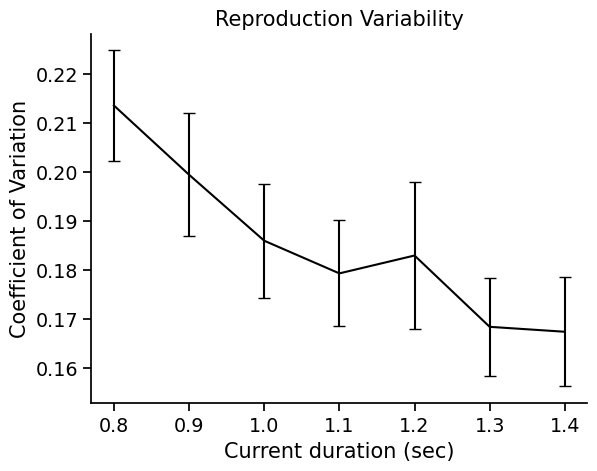

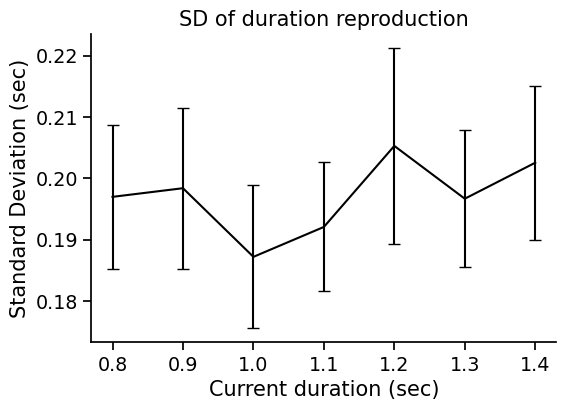

In [9]:
# overall mean reproduction CV
RprCV = dataRpr.groupby(['nPar']).agg({"rpr":["count","mean","std"]}).reset_index()
RprCV.columns = ['nPar', 'count', 'mean','std']
RprCV['cv'] = RprCV['std']/RprCV['mean']
# print(RprCV)
print('mean of overall CV:',RprCV["cv"].mean().round(3))
print('SE of overall CV:',RprCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(RprCV['cv'], 0).round(3))

# mean CV as a factor of duration
mCVPar = dataRpr.groupby(['nPar', 'curDur']).\
    agg({"rpr":["count","mean","std"]}).reset_index()
mCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mCVPar['cv'] = mCVPar['std']/mCVPar['mean']
mCVAll = mCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_cv_dur = rmANOVA_gg_Long(mCVPar, 'cv', ['curDur'], 'nPar')
# print(aov_cv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mCVAll, 
             color='black', capsize=4)
plt.xticks(mCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Reproduction Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mSDAll = mCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mSDAll,color='black',capsize=4)
plt.xticks(mSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of duration reproduction')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

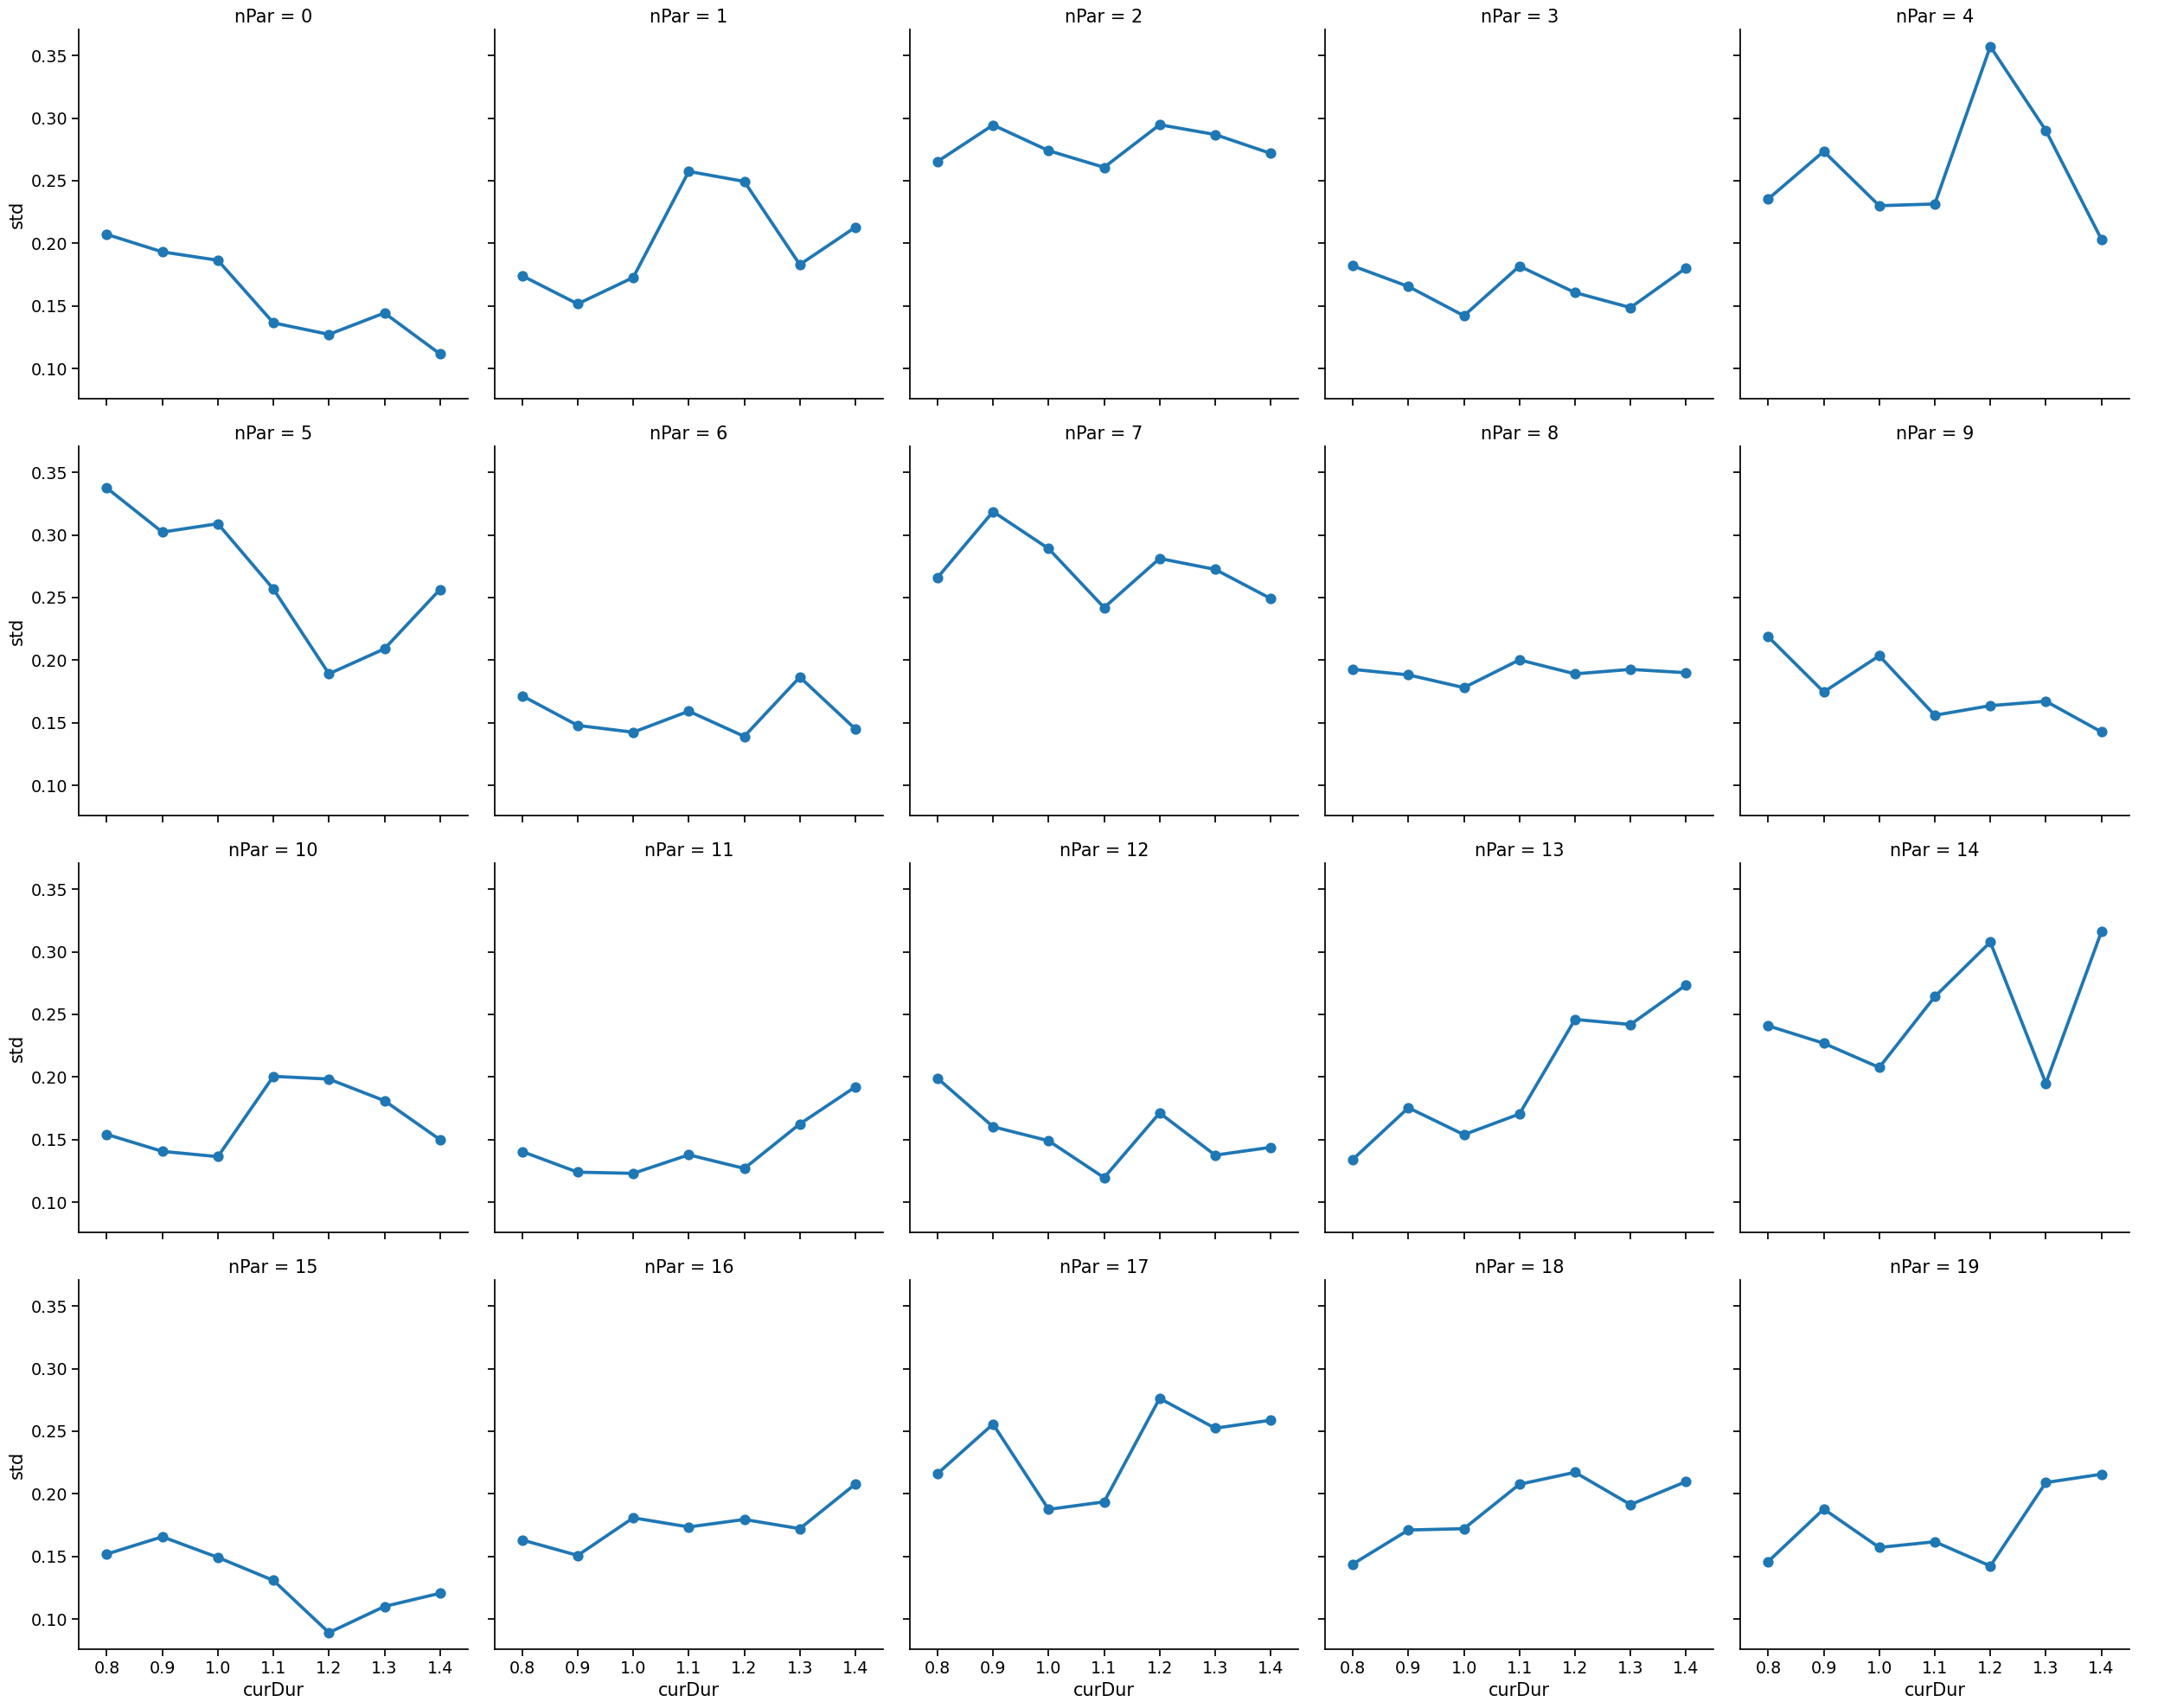

In [10]:
# quickly visualize the individual data
sns.catplot(data = mCVPar, kind = 'point', 
            x = 'curDur', y = 'std', col = 'nPar', col_wrap = 5)

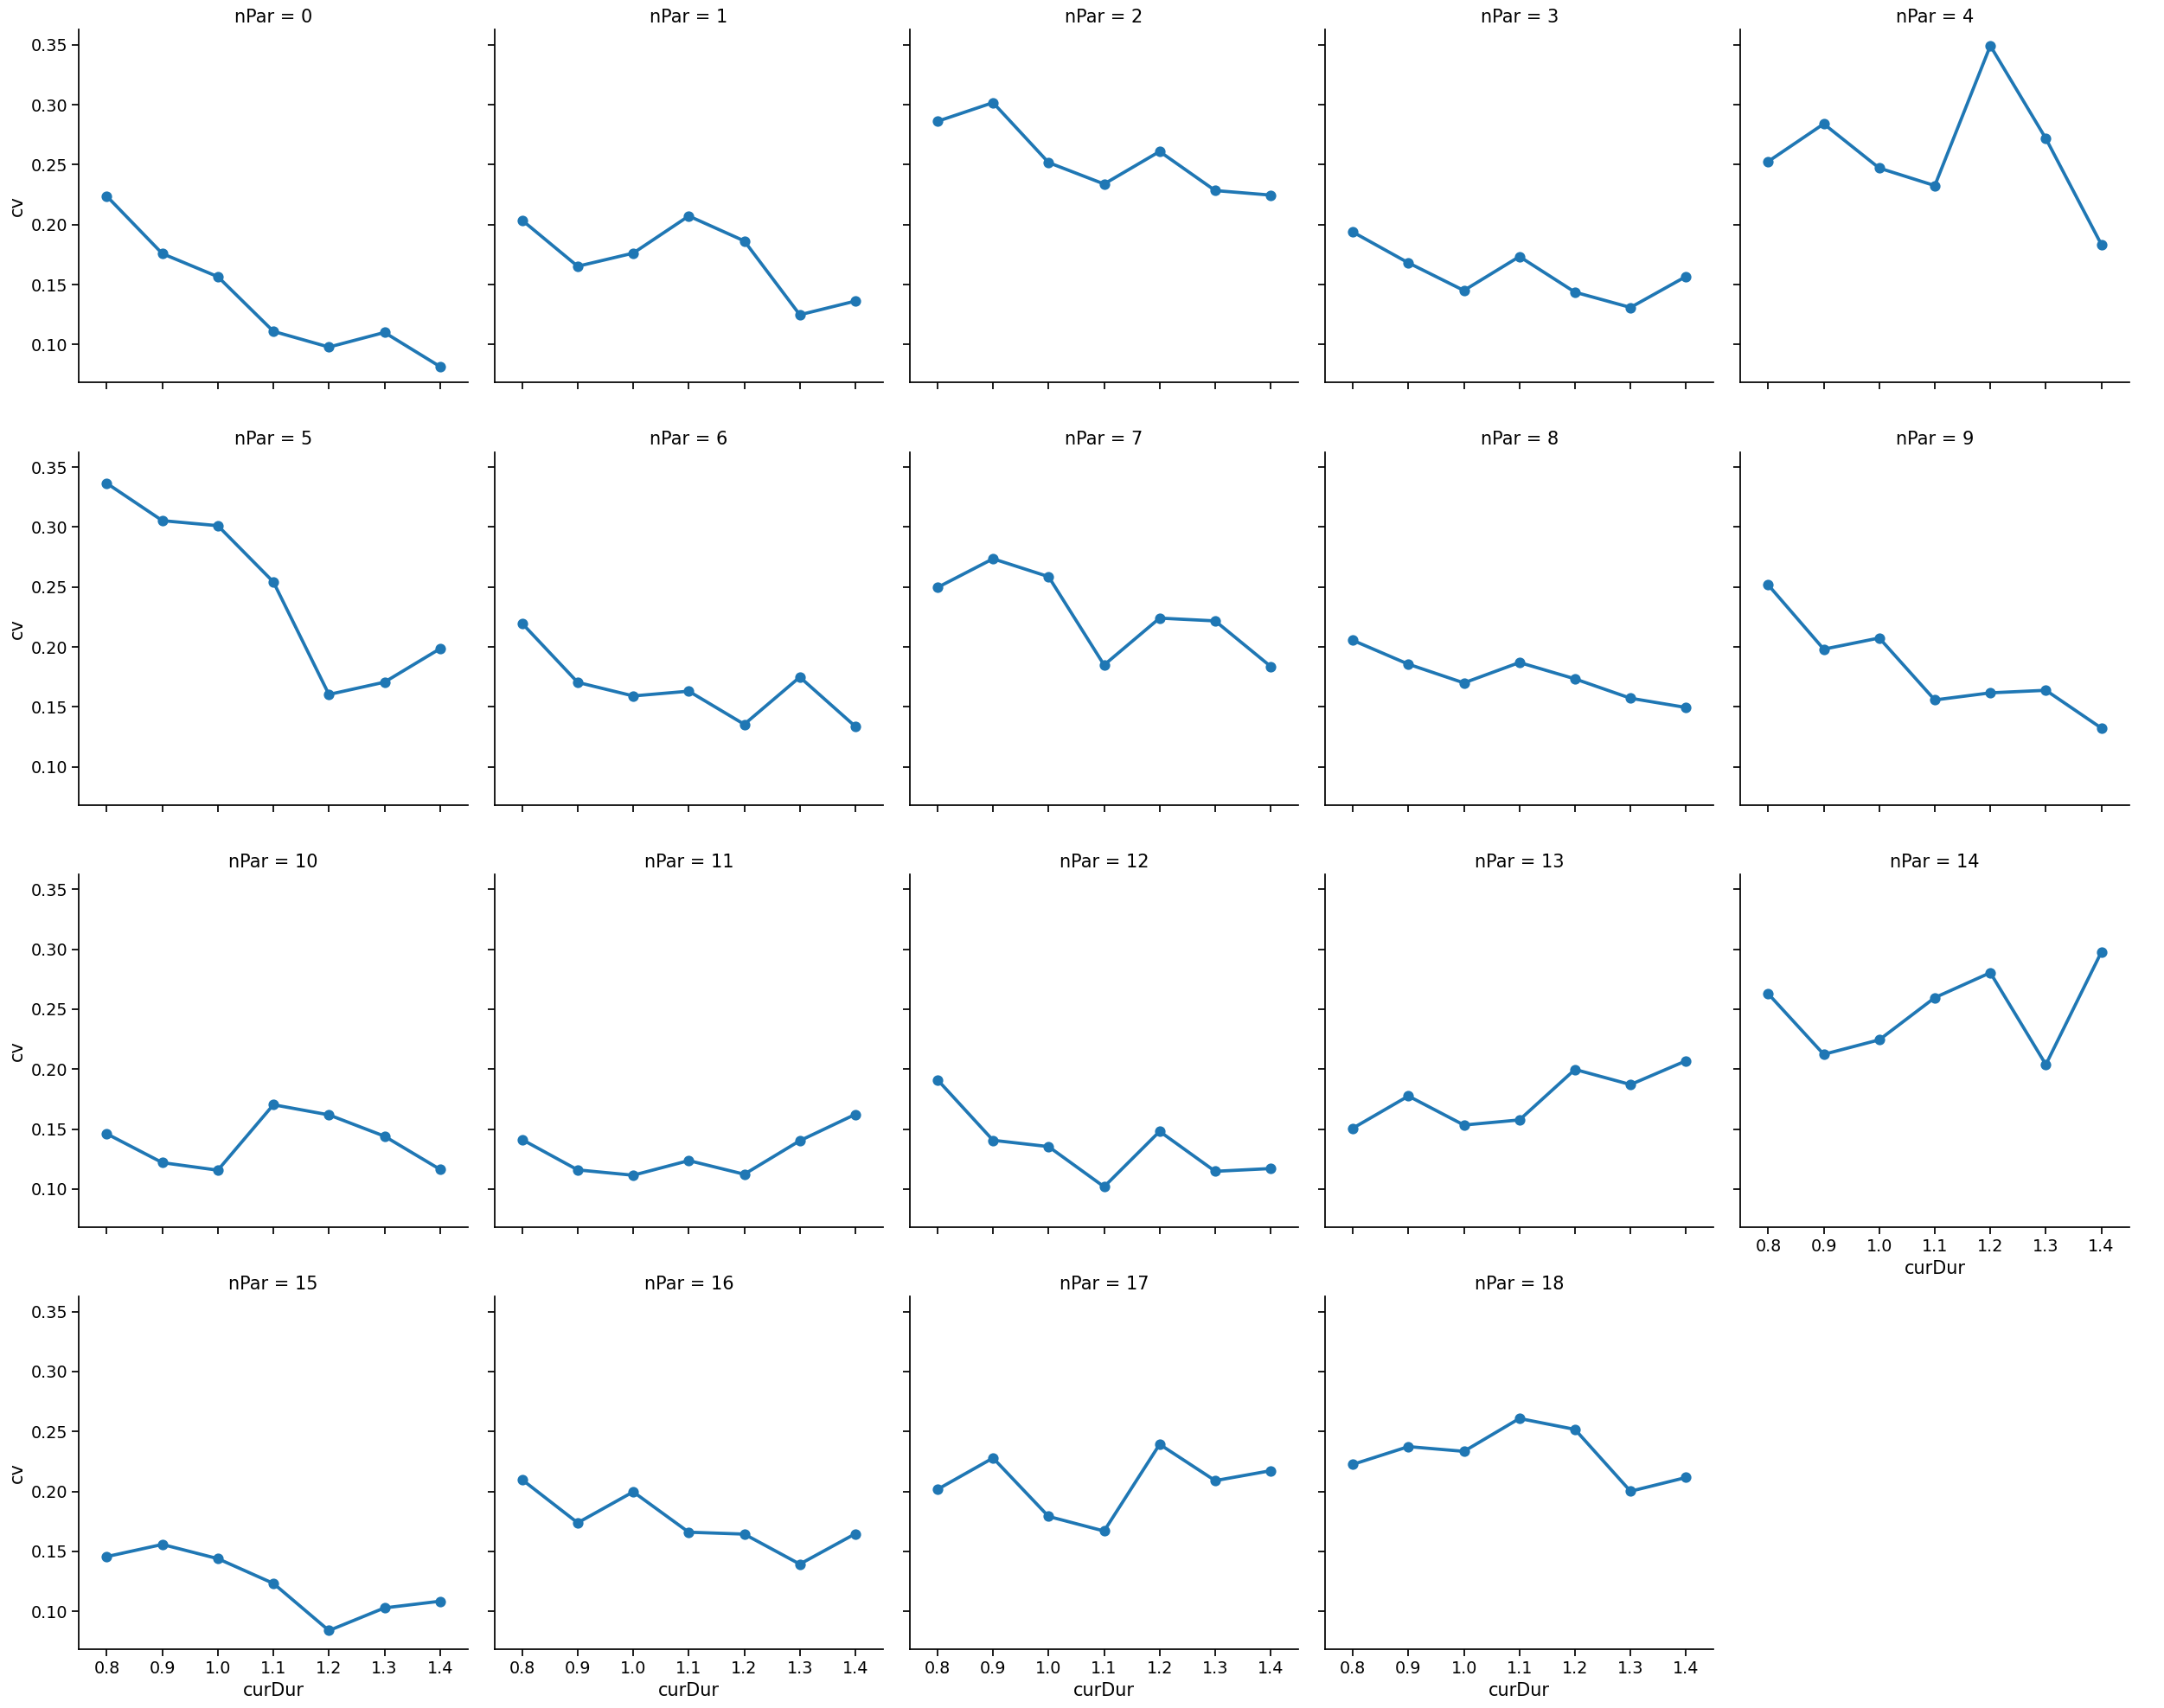

In [14]:
# quickly visualize the individual data
sns.catplot(data = mCVPar, kind = 'point', 
            x = 'curDur', y = 'cv', col = 'nPar', col_wrap = 5)

### 1.2 Central tendency effect

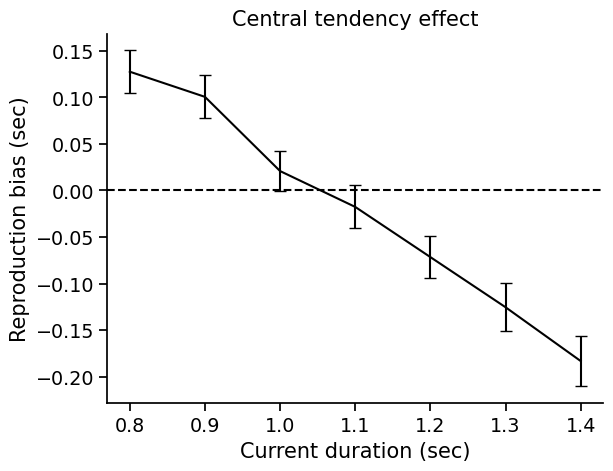

In [188]:
# Central tendency based on Reproduction Bias
mBiasDurPar = dataRpr.groupby(['nPar', 'curDur']).curBias.mean().reset_index()
mBiasDurAll = mBiasDurPar.groupby('curDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasDurAll.columns = ['curDur', 'count', 'mBias','seBias']
#print(mBiasDurAll)

# rmANOVA: mean bias as a factor of duration
# print('【rmANOVA: Duration main effect on mean bias】')
# aov_bias_dur = rmANOVA_gg_Long(mBiasDurPar, 'curBias', ['curDur'], 'nPar')
# print(aov_bias_dur)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mBias', yerr='seBias', data=mBiasDurAll, 
             color='black', capsize=4)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mBiasDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(figsDir + '/CT_RprErr.png', bbox_inches='tight')

# # Central tendency based on Reproduction
# mRprDurPar = dataRpr.groupby(['nPar', 'curDur']).rpr.mean().reset_index()
# mRprDurAll = mRprDurPar.groupby('curDur').\
#     agg({"rpr":["count","mean","sem"]}).reset_index()
# mRprDurAll.columns = ['curDur', 'count', 'mRpr','seRpr']
# #print(mRprDurAll)

# # plot central tendency
# fig, ax = plt.subplots()
# plt.errorbar(x='curDur', y='mRpr', yerr='seRpr', data=mRprDurAll, 
#              color='black', capsize=4)
# plt.plot([0.8, 1.4], [0.8, 1.4], 'k-', lw=1, dashes=[2, 2])
# plt.xticks(mRprDurAll.curDur)
# plt.xlabel('Current duration (sec)')
# plt.ylabel('Reproduction (sec)')
# plt.title('Central tendency effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# #plt.savefig(figsDir + '/CT_Rpr.png', bbox_inches='tight')

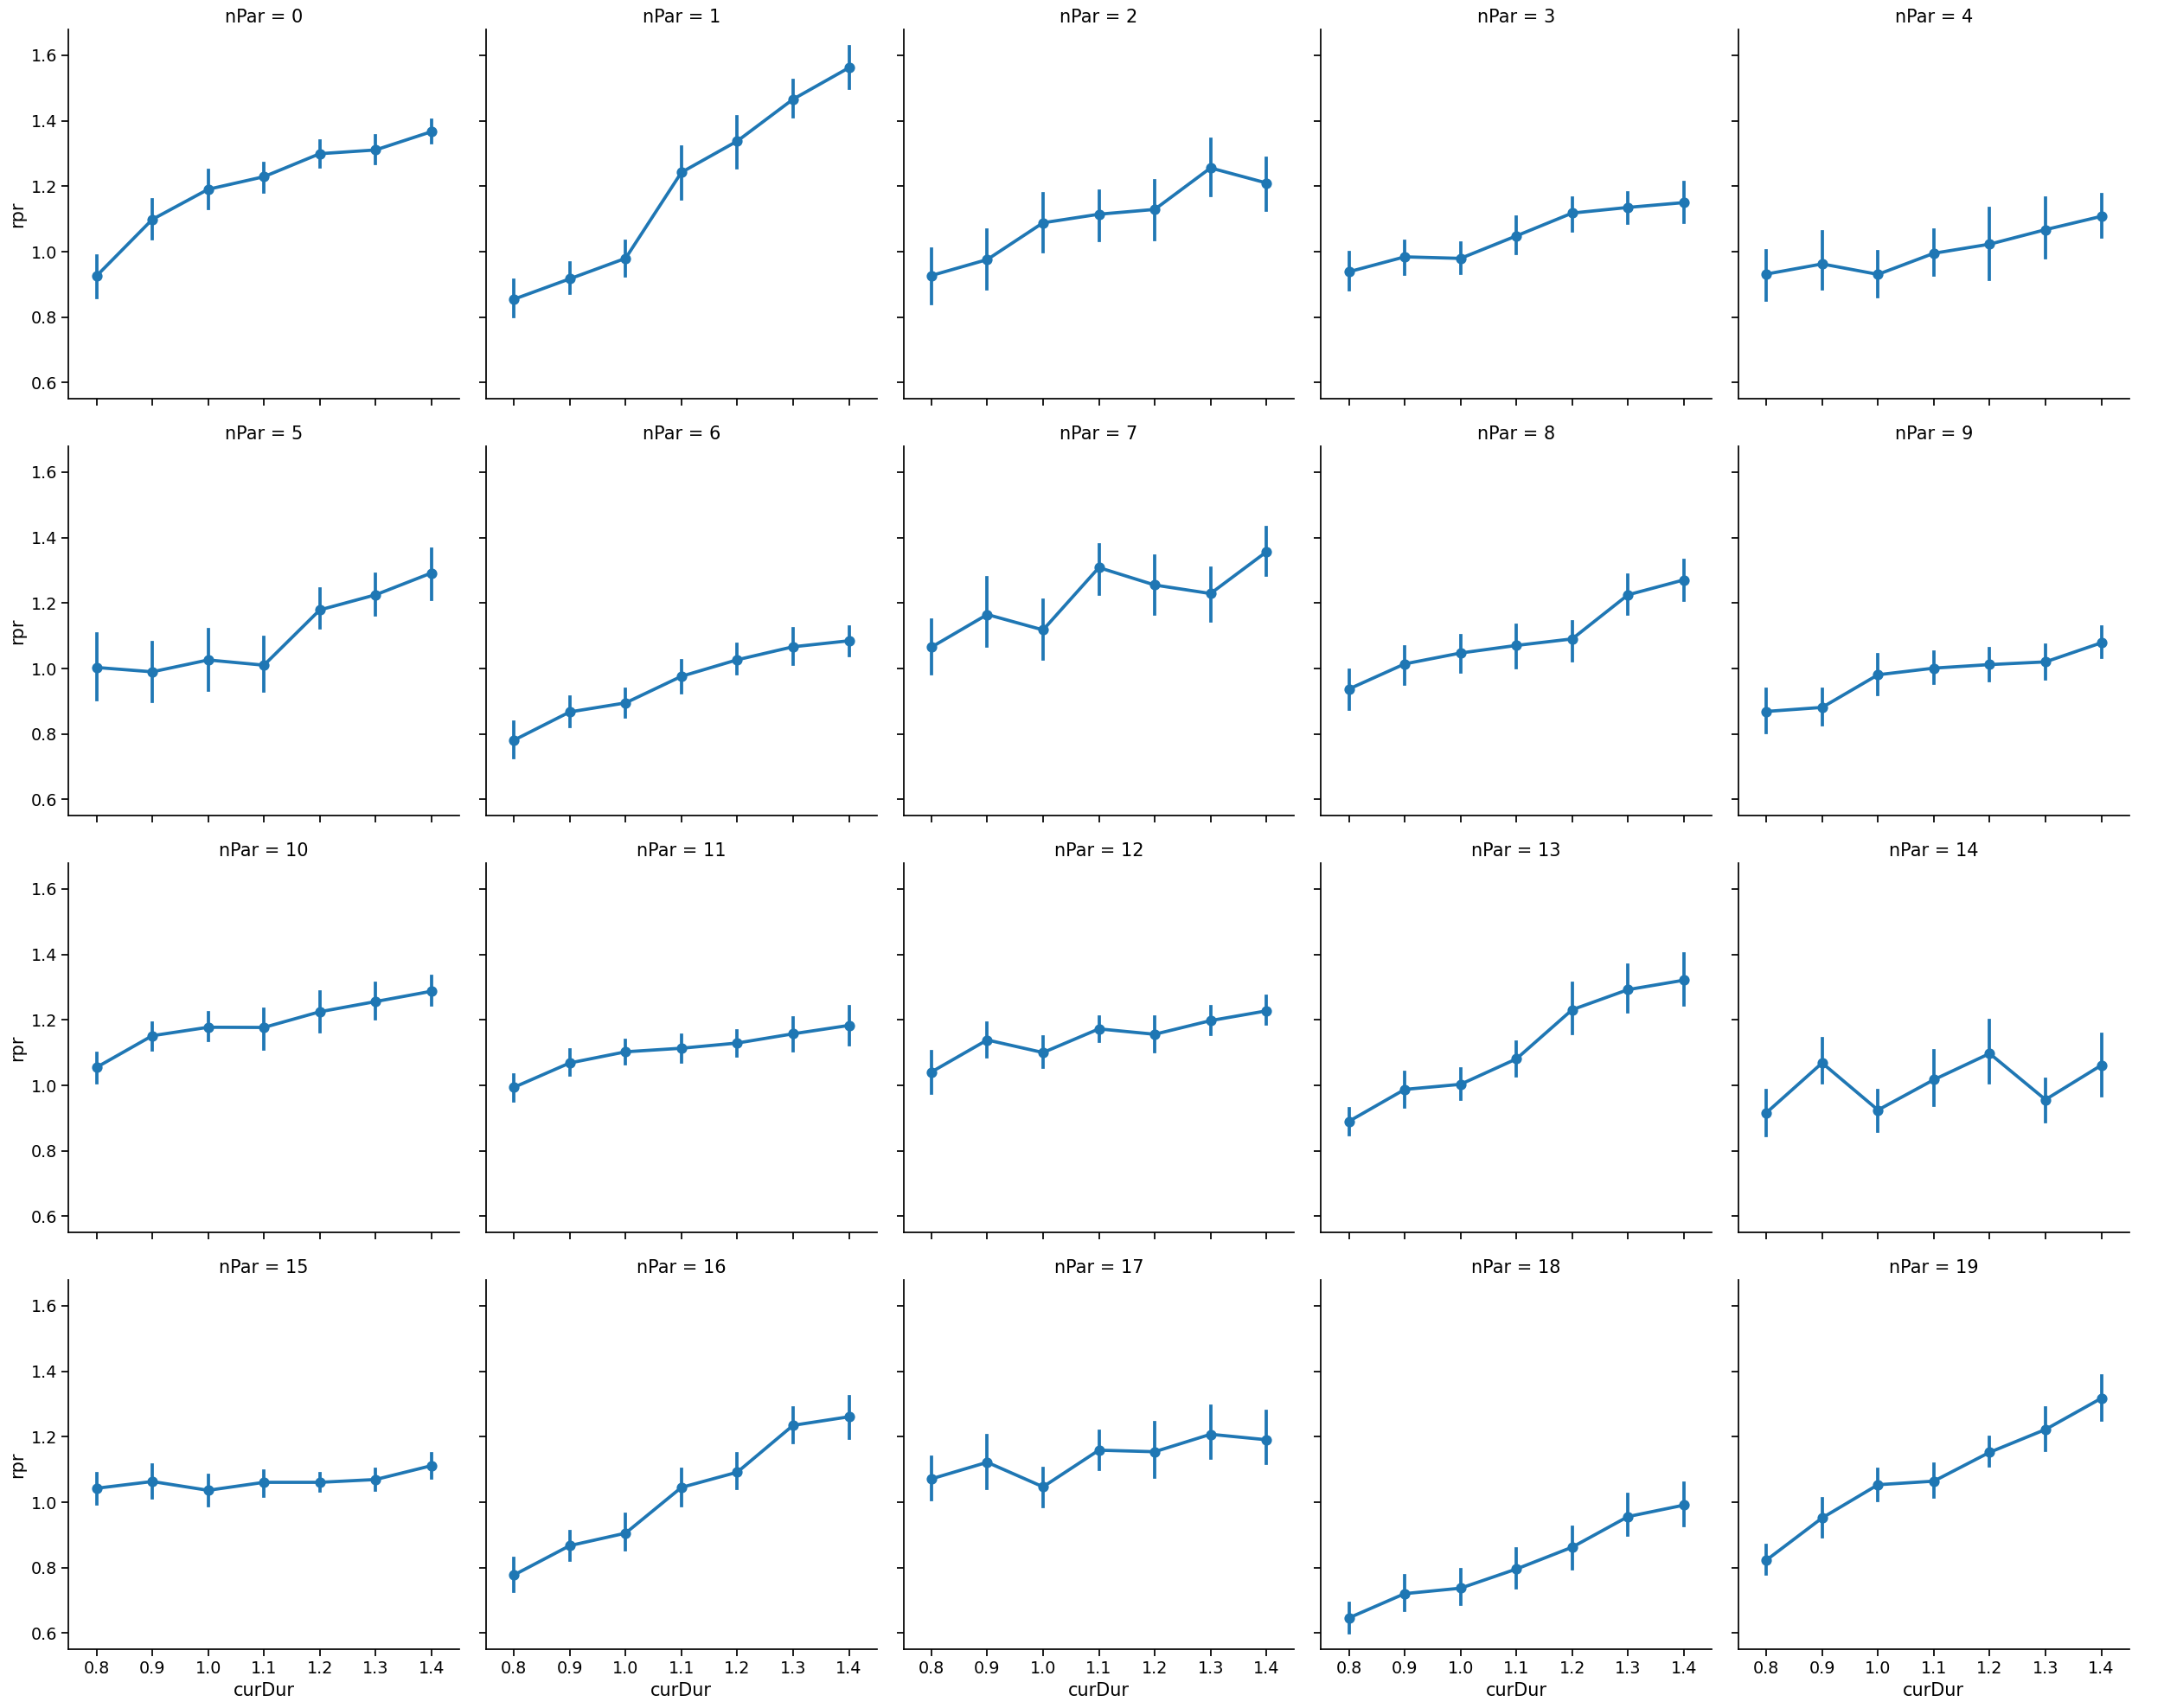

In [12]:
# quickly visualize the individual data
sns.catplot(data = dataRpr, kind = 'point', 
            x = 'curDur', y = 'rpr', col = 'nPar', col_wrap = 5)

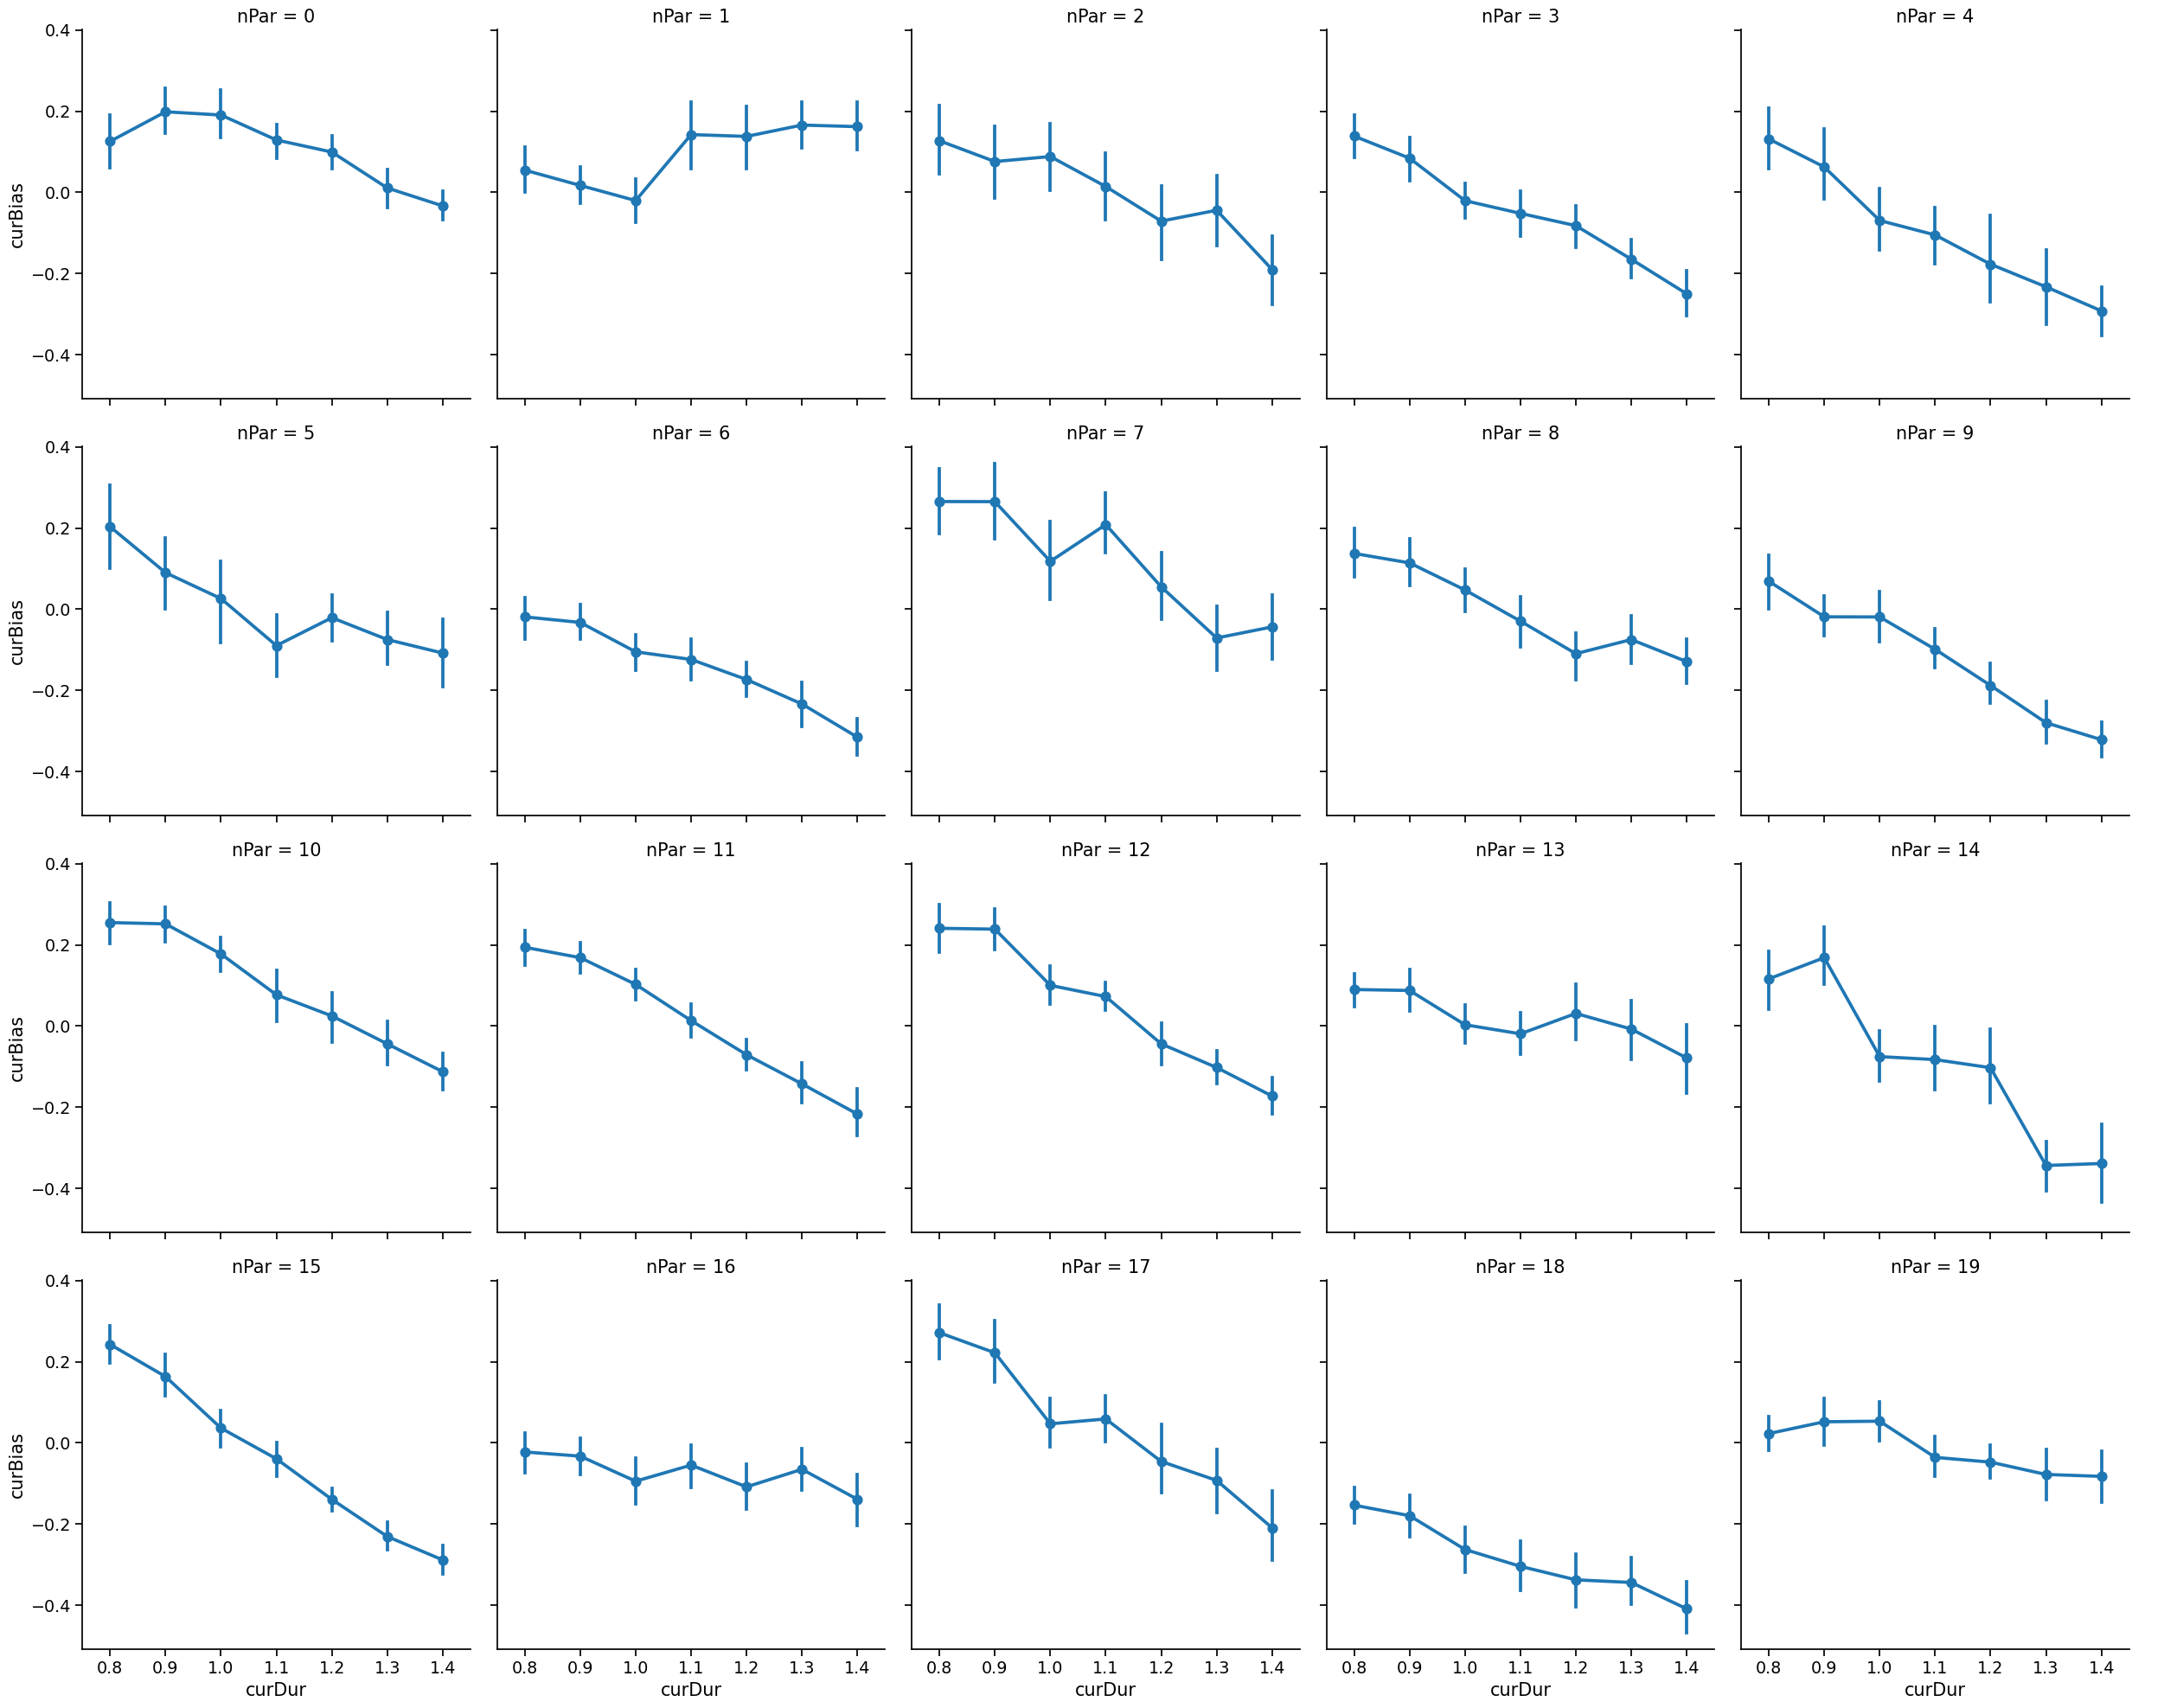

In [13]:
# quickly visualize the individual data
sns.catplot(data = dataRpr, kind = 'point', 
            x = 'curDur', y = 'curBias', col = 'nPar', col_wrap = 5)

### 1.3 Sequential effect or Serial dependence

In [189]:
# overall Sequential effect (based on Reproduction Bias)
mBiasPreDurPar = dataRpr_pre.groupby(['nPar','preDur']).curBias.mean().reset_index()
mBiasPreDurAll = mBiasPreDurPar.groupby('preDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasPreDurAll.columns = ['preDur', 'count', 'mBias','seBias']
# print(mBiasPreDurAll)

# rmANOVA: mean bias as a factor of pre-duration
# print('【rmANOVA of mean Bias on preDuration】')
# aov_bias_preDur = rmANOVA_gg_Long(mBiasPreDurPar, 'curBias', ['preDur'], 'nPar')
# print(aov_bias_preDur)

# plot sequential effect
# fig, ax = plt.subplots()
# plt.errorbar(x='preDur', y='mBias', yerr='seBias', data=mBiasPreDurAll, 
#              color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.xticks(mBiasPreDurAll.preDur)
# plt.xlabel('Duration of previous n-1 trial (sec)')
# plt.ylabel('Reproduction bias (sec)')
# plt.title('overall Sequential effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_RprErr.png', bbox_inches='tight')

#### serial dependence between RR and FR

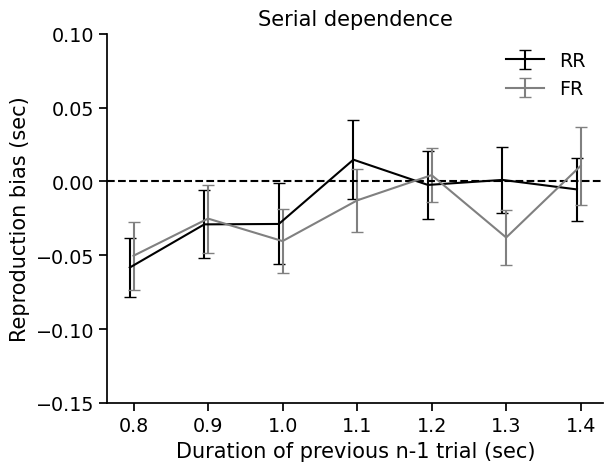

In [190]:
# Sequential effect between RR and FR
seqTaskPar = dataRpr_pre.groupby(['nPar', 'preTask', 'preDur']).curBias.mean().reset_index()
seqTaskAll = seqTaskPar.groupby(['preTask', 'preDur']).\
    agg({"curBias":["count","mean","sem"]}).reset_index()
seqTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
# print(seqTaskAll)

# plot sequential effect between RR and JR
data_RR = seqTaskAll.query('preTask=="reproduction"')
data_FR = seqTaskAll.query('preTask=="following"')
data_pFR = dataRpr_pre.query('preTask=="following"').\
    groupby(['nPar', 'prePreCueDur']).curBias.mean().reset_index().\
    groupby(['prePreCueDur']).agg({"curBias":["count","mean","sem"]}).reset_index()
data_pFR.columns = ['prePreCueDur', 'count', 'mBias','seBias']

fig, ax = plt.subplots()
ax.errorbar(data_RR.preDur-0.005, data_RR.mBias, data_RR.seBias, 
             color='black', capsize=4, label='RR')
ax.errorbar(data_FR.preDur, data_FR.mBias, data_FR.seBias, 
             color='grey', capsize=4, label='FR')
# ax.errorbar(data_pFR.prePreCueDur+0.005, data_pFR.mBias, data_pFR.seBias, 
#              color='grey', capsize=4, label='pFR', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_RR.preDur)
plt.ylim(-0.15, 0.1)
plt.xlabel('Duration of previous n-1 trial (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('Serial dependence')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_RRvsFR.png', bbox_inches='tight')

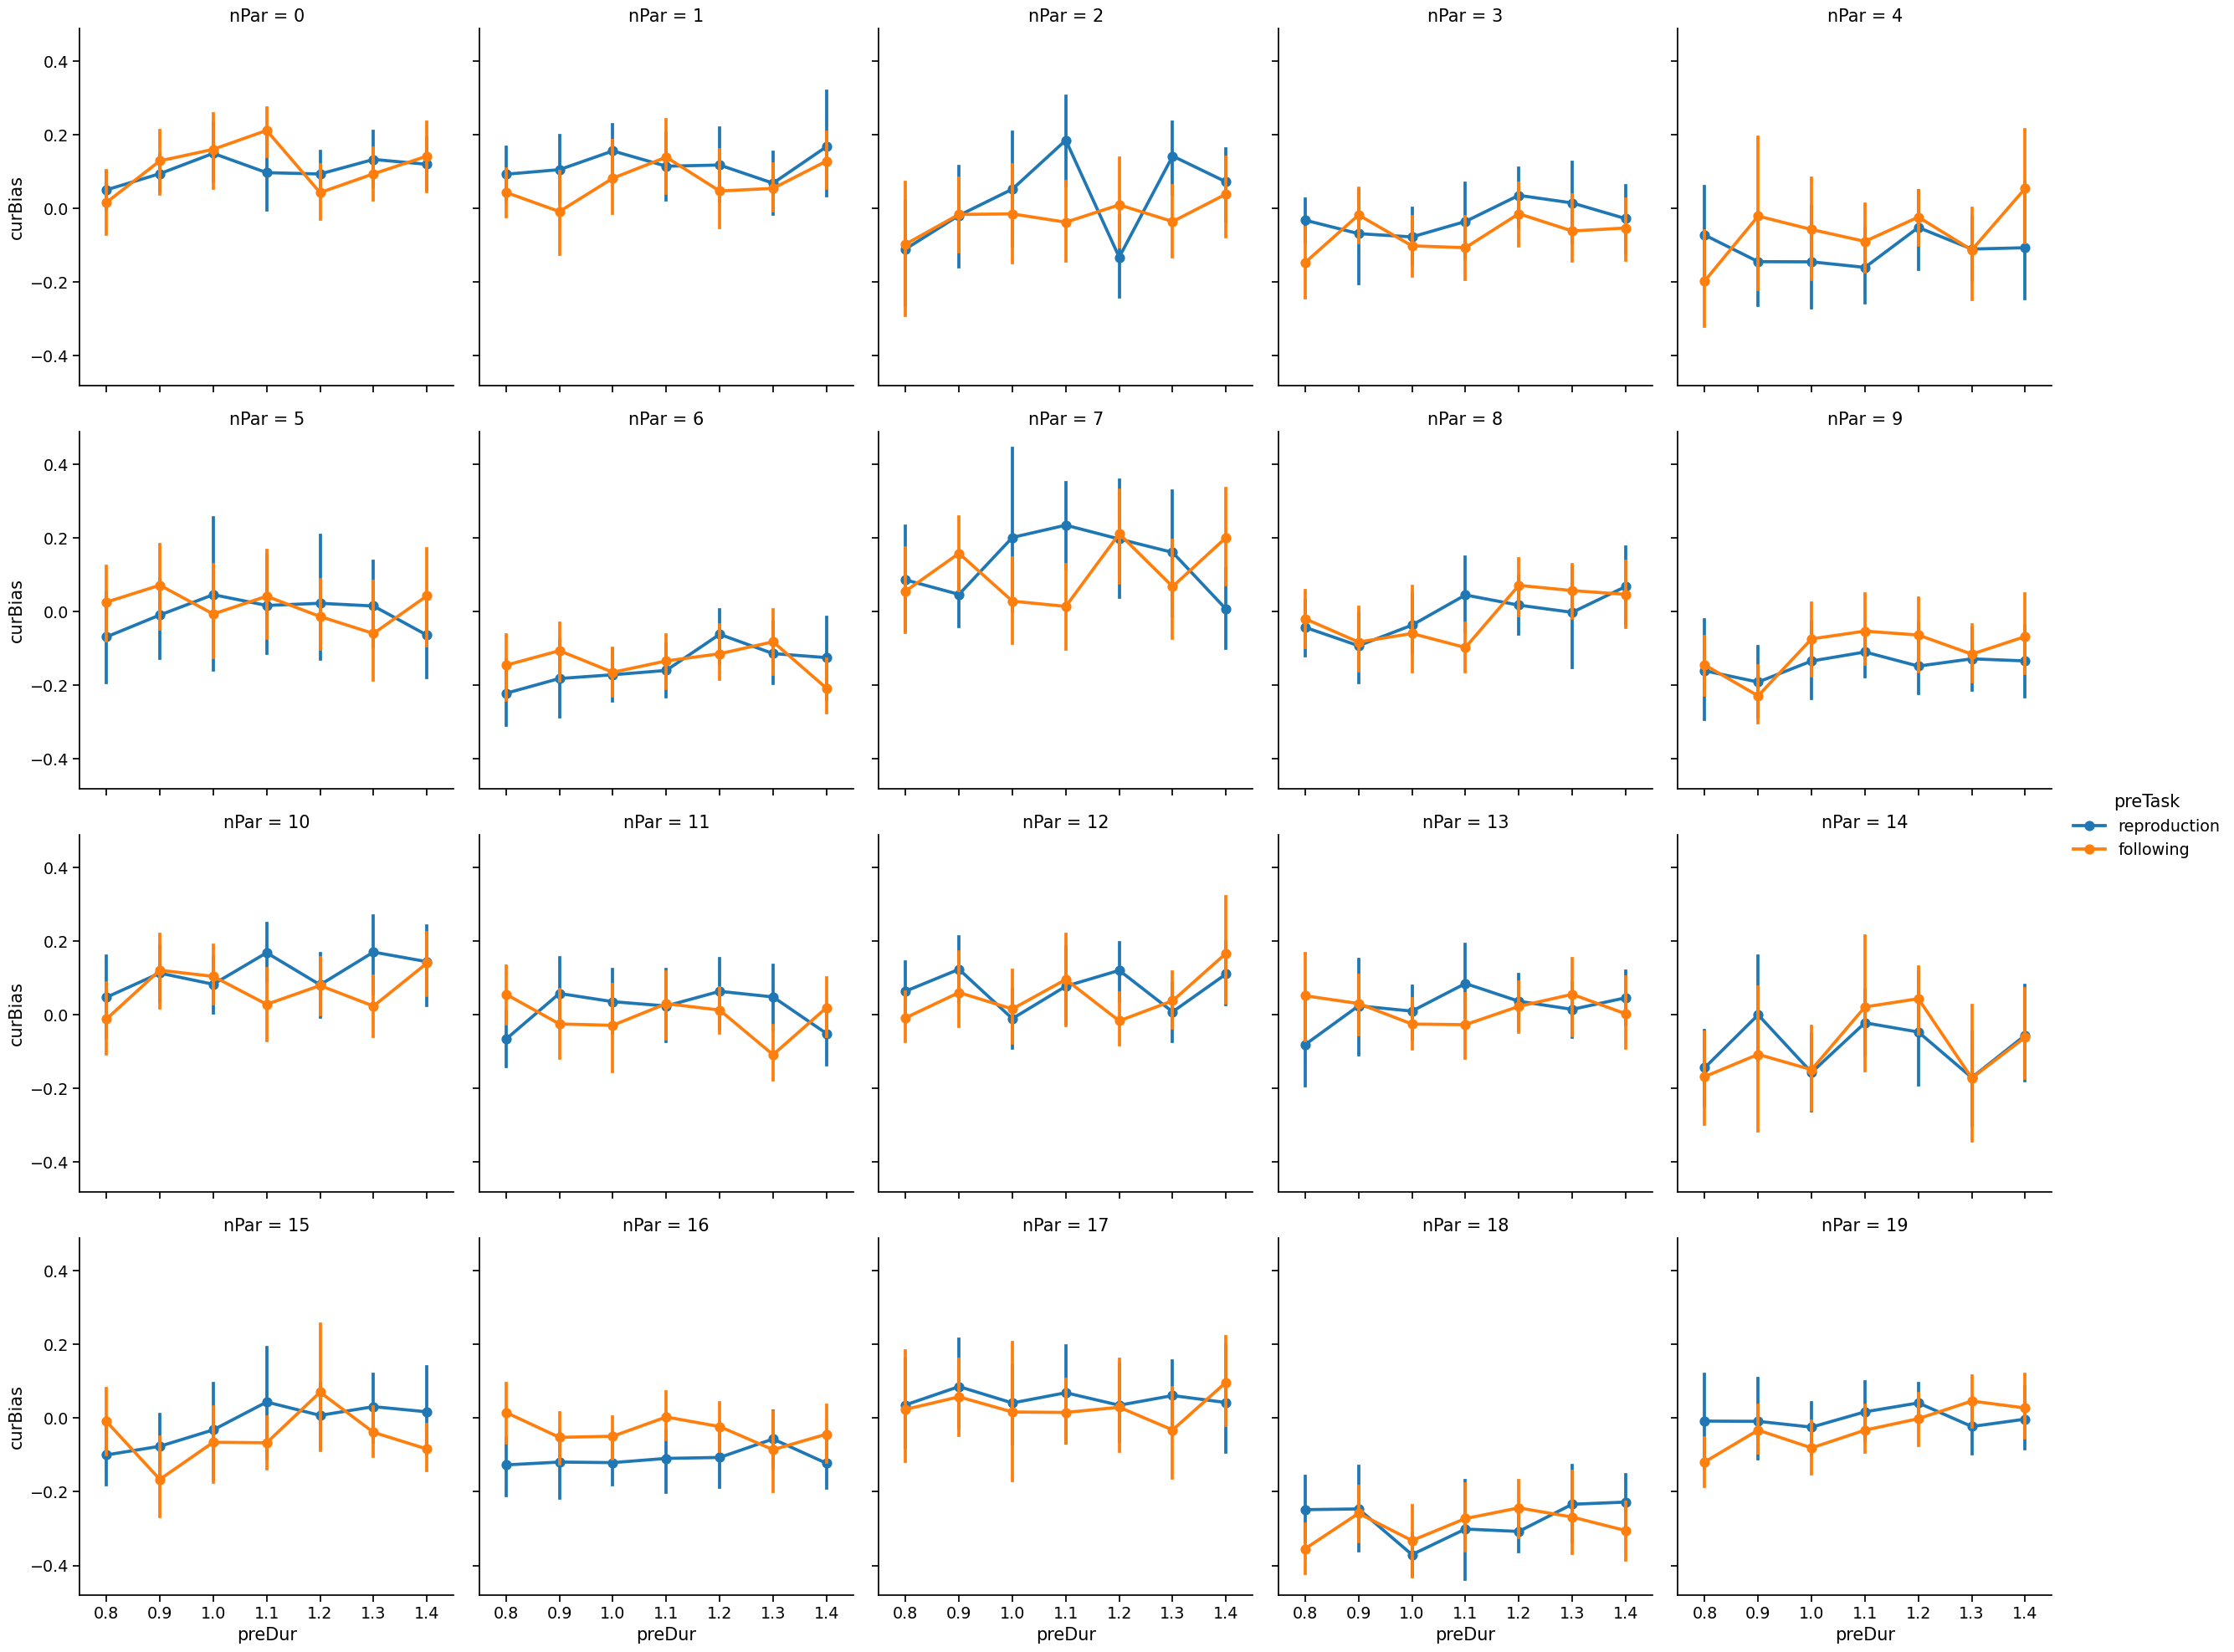

In [17]:
# quickly visualize the individual data
sns.catplot(data = dataRpr_pre, kind = 'point', 
            x = 'preDur', y = 'curBias', hue='preTask', col = 'nPar', col_wrap = 5)

mean SDI slope in RR:  0.064
std SDI slope in RR:  0.013
              T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  4.97757   21   two-sided  0.00006  [0.04, 0.09]  1.06122  414.01   

          power  
T-test  0.99728  
mean SDI slope in FR:  0.074
std SDI slope in FR:  0.021
              T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  3.39696   21   two-sided  0.00272  [0.03, 0.12]  0.72424  15.046   

          power  
T-test  0.89938  
【Comparison of SDI in RR vs FR】
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test -0.36879   21   two-sided  0.71598  [-0.06, 0.04]  0.11506  0.237   

          power  
T-test  0.08095  


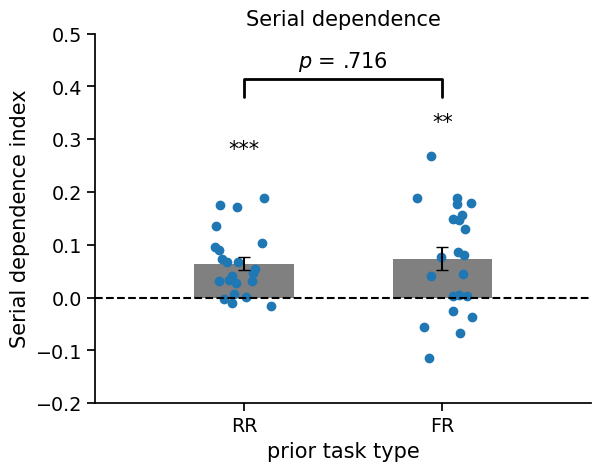

In [192]:
# calculate SDI (RR vs FR) and plot
dataRR = dataRpr_pre.query('preTask=="reproduction"')
dataFR = dataRpr_pre.query('preTask=="following"')

slp_1, slope_RR_sdi, int_1 = LM_2F(dataRR, ['curDur','preDur','curBias'])
slp_1, slope_FR_sdi, int_1 = LM_2F(dataFR, ['curDur','preDur','curBias'])

# # using simple linear regression
# slope_RR_sdi, int_1 = LM_1F(dataRR, ['preDur','curBias'])
# slope_FR_sdi, int_1 = LM_1F(dataFR, ['preDur','curBias'])

print("mean SDI slope in RR: ", slope_RR_sdi.mean().round(3))
print("std SDI slope in RR: ", round(slope_RR_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RR_sdi, 0).round(5))
print("mean SDI slope in FR: ", slope_FR_sdi.mean().round(3))
print("std SDI slope in FR: ", round(slope_FR_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FR_sdi, 0).round(5))
print("【Comparison of SDI in RR vs FR】")
print(pg.ttest(slope_RR_sdi, slope_FR_sdi, paired=True).round(5))

# Custom function to draw the diff bars
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':30,'shrinkB':30,'linewidth':2}
    ax.annotate(text, xy=(X[i]+dx*3/11,y*1.45), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi)],
             yerr=[np.std(slope_RR_sdi)/np.sqrt(nPar), np.std(slope_FR_sdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2], \
            [slope_RR_sdi, slope_FR_sdi])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['RR', 'FR'])
plt.yticks(np.arange(-0.2, 0.57, 0.1))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
plt.title('Serial dependence')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('***', xy=(1,0.27), zorder=10, ha='center')
ax.annotate('**', xy=(2,0.32), zorder=10, ha='center')
label_diff(0,1,'$\mathit{p}$ = .716', np.arange(1,3), [np.mean(slope_RR_sdi)+0.2, np.mean(slope_FR_sdi)+0.2])

plt.savefig(figsDir + '/SeqEff_RRvsFR_SDI.png', bbox_inches='tight')

#### pre-cue stimulus in follow condition

mean SDI slope for pre-cue stimuli in follow condition:  0.04
std SDI slope in pre-cue stimuli in follow condition:  0.024
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  1.63953   19   two-sided  0.11756  [-0.01, 0.09]  0.36661  0.726   

          power  
T-test  0.34367  


Text(0.5, 1.0, 'Serial dependence')

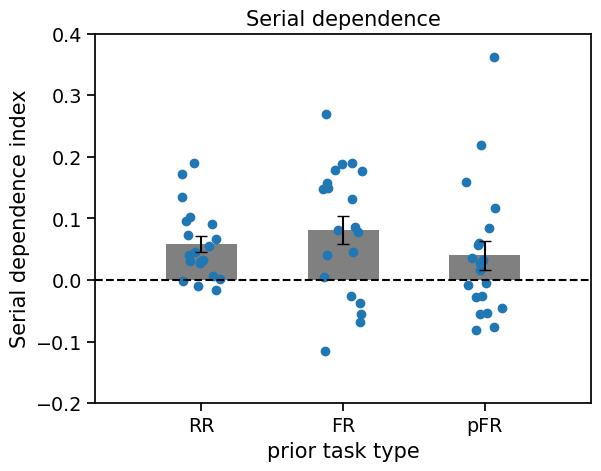

In [55]:
# calculate the serial dependence of pre-cue stimuli in follow condition
slp_1, slope_FR_psdi, int_1 = LM_2F(dataFR, ['curDur','prePreCueDur','curBias'])
# # using simple linear regression
# slope_FR_psdi, int_1 = LM_1F(dataFR, ['prePreCueDur','curBias'])
print("mean SDI slope for pre-cue stimuli in follow condition: ", slope_FR_psdi.mean().round(3))
print("std SDI slope in pre-cue stimuli in follow condition: ", round(slope_FR_psdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FR_psdi, 0).round(5))

# plot serial dependence from the pre-cue perceptual stimuli (pFR)
fig, ax = plt.subplots()
plt.bar(np.arange(1,4), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi), np.mean(slope_FR_psdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,4), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi), np.mean(slope_FR_psdi)],
             yerr=[np.std(slope_RR_sdi)/np.sqrt(nPar), np.std(slope_FR_sdi)/np.sqrt(nPar), np.std(slope_FR_psdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2, (np.random.random(nPar)-0.5)*0.3+3], \
            [slope_RR_sdi, slope_FR_sdi, slope_FR_psdi])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,3.75)
plt.xticks(np.arange(1,4), ['RR', 'FR','pFR'])
plt.yticks(np.arange(-0.2, 0.47, 0.1))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
plt.title('Serial dependence')

In [56]:
slp, b = LM_1F(dataFlw.query('curTask=="following"'), ['curDur','curPreCueDur'])
print(slp)

# plt.figure()
# sns.lmplot(data=dataFlw.query('curTask=="following"'), x="curDur", y="curPreCueDur", scatter_kws={"s": 4}) # 

[-0.09335206 -0.0625421  -0.00422222 -0.06487062  0.01141384  0.04078074
 -0.06217182  0.03431901 -0.00876238 -0.13255065  0.13117871  0.06660346
  0.01917614  0.00093105  0.06624246 -0.02042273  0.10779562 -0.00486144
 -0.17186223 -0.04445366]


#### decisional carryover effect

<Figure size 640x480 with 0 Axes>

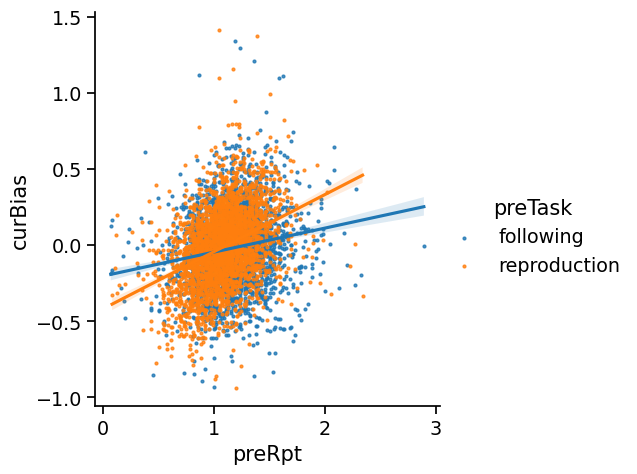

In [193]:
plt.figure()
sns.lmplot(data=dataRpr_pre.query('preRpt<3'), x="preRpt", y="curBias", hue='preTask', scatter_kws={"s": 4}) # 
plt.savefig(figsDir + '/SeqEff_RRvsFR_DCI_scatter.png', bbox_inches='tight')

mean SDI slope in RR:  0.257
std SDI slope in RR:  0.02
               T  dof alternative  p-val        CI95%  cohen-d       BF10  \
T-test  12.43631   21   two-sided    0.0  [0.21, 0.3]  2.65143  2.372e+08   

        power  
T-test    1.0  
mean SDI slope in FR:  0.155
std SDI slope in FR:  0.024
              T  dof alternative  p-val        CI95%  cohen-d      BF10  \
T-test  6.17652   21   two-sided    0.0  [0.1, 0.21]  1.31684  5074.398   

          power  
T-test  0.99995  
【Comparison of SDI in RR vs FR】
              T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  3.75574   21   two-sided  0.00116  [0.05, 0.16]  0.95577  31.371   

          power  
T-test  0.98955  


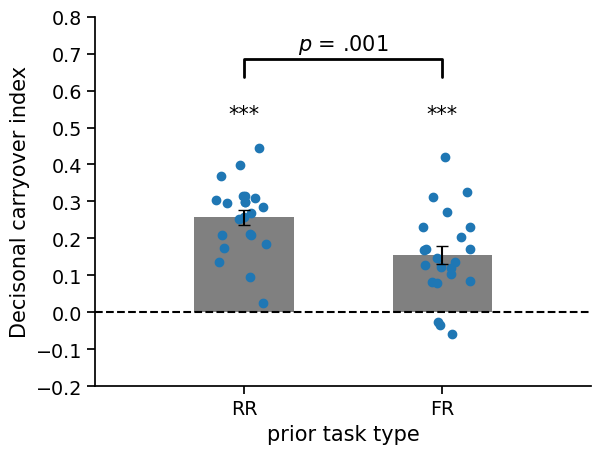

In [195]:
# calculate Decisional carry-over index (DCI) and plot
slp_1, slope_RR_dci, int_1 = LM_2F(dataRR, ['curDur','preRpt','curBias'])
print("mean SDI slope in RR: ", slope_RR_dci.mean().round(3))
print("std SDI slope in RR: ", round(slope_RR_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RR_dci, 0).round(5))

slp_1, slope_FR_dci, int_1 = LM_2F(dataFR, ['curDur','preRpt','curBias'])
print("mean SDI slope in FR: ", slope_FR_dci.mean().round(3))
print("std SDI slope in FR: ", round(slope_FR_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FR_dci, 0).round(5))

print("【Comparison of SDI in RR vs FR】")
print(pg.ttest(slope_RR_dci, slope_FR_dci, paired=True).round(5))

# Custom function to draw the diff bars
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':30,'shrinkB':30,'linewidth':2}
    ax.annotate(text, xy=(X[i]+dx*3/11,y*1.35), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_RR_dci), np.mean(slope_FR_dci)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_RR_dci), np.mean(slope_FR_dci)],
             yerr=[np.std(slope_RR_dci)/np.sqrt(nPar), np.std(slope_FR_dci)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2],\
            [slope_RR_dci, slope_FR_dci])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['RR', 'FR'])
plt.yticks(np.arange(-0.2, 0.81, 0.1))
plt.xlabel('prior task type')
plt.ylabel('Decisonal carryover index')
# plt.title('Decisonal carry-over effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('***', xy=(1,0.52), zorder=10, ha='center')
ax.annotate('***', xy=(2,0.52), zorder=10, ha='center')
label_diff(0,1,'$\mathit{p}$ = .001', np.arange(1,3), [np.mean(slope_RR_dci)+0.22, np.mean(slope_FR_dci)+0.22])

plt.savefig(figsDir + '/SeqEff_RRvsFR_DCI.png', bbox_inches='tight')

#### calculate the Deviate index (Wang et al., 2023)

/var/folders/v_/jy236dx55zzbb5vvpjc0s00w0000gn/T/ipykernel_55016/3868756355.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


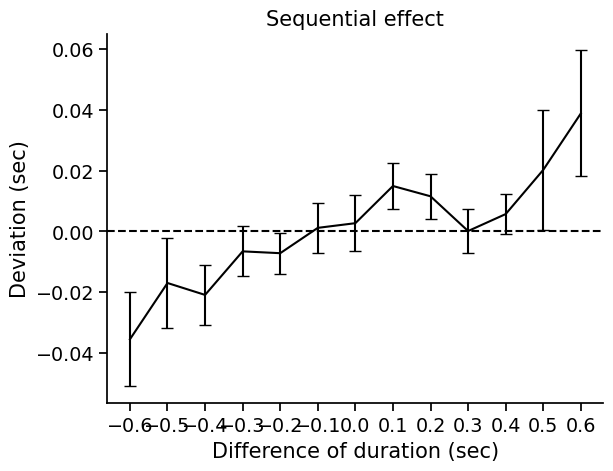

In [25]:
# Sequential effect between RR and JR: 
# calculate deviation index as function of difference between stimuli (preDur-curDur)
dataRpr_pre['diffDur'] = round(dataRpr_pre['preDur'] - dataRpr_pre['curDur'],2)
tmp = dataRpr_pre
a = 1
tmp['devGrp'] = tmp['diffDur'] #round(tmp['diffDur']/a)
devPar = tmp.groupby(['nPar', 'devGrp']).deviat.mean().reset_index()
devAll = devPar.groupby(['devGrp']).\
    agg({"deviat":["count","mean","sem"]}).reset_index()
devAll.columns = ['devGrp', 'count', 'mDev','seDev']
# print(devAll)

# plot sequential effect between RR and JR
fig, ax = plt.subplots()
ax.errorbar(devAll.devGrp, devAll.mDev, devAll.seDev, 
             color='black', capsize=4)
# plt.scatter(x=tmp.devIdx, y=tmp.deviat, s=1)
# plt.scatter(x=devPar.devGrp,y=devPar.deviat, s=1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(devAll.devGrp)
# plt.yticks(np.arange(-100, 126, 25))
# ax.set_yscale('log')
plt.xlabel('Difference of duration (sec)')
plt.ylabel('Deviation (sec)')
plt.title('Sequential effect')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/exp1_SeqEff_RRvsJR.png', bbox_inches='tight')

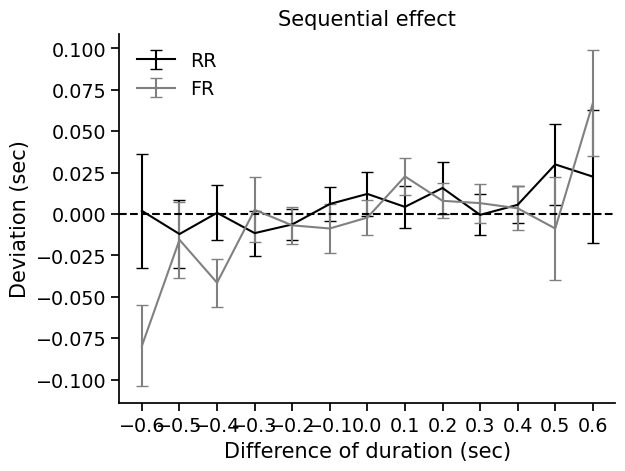

In [26]:
a = 350
# tmp['devIdx'] = tmp['diffDur']/a
# tmp['devGrp'] = round(tmp['diffDur']/a)
tmp['devGrp'] = tmp['diffDur'] #round(tmp['diffDur']/a)
devTaskPar = tmp.groupby(['nPar', 'preTask', 'devGrp']).deviat.mean().reset_index()
devTaskAll = devTaskPar.groupby(['preTask', 'devGrp']).\
    agg({"deviat":["count","mean","sem"]}).reset_index()
devTaskAll.columns = ['preTask', 'devGrp', 'count', 'mDev','seDev']
# print(devTaskAll)

# plot sequential effect between RR and JR
data_devRR = devTaskAll.query('preTask=="reproduction"')
data_devJR = devTaskAll.query('preTask=="following"')

fig, ax = plt.subplots()
ax.errorbar(data_devRR.devGrp, data_devRR.mDev, data_devRR.seDev, 
             color='black', capsize=4, label='RR')
ax.errorbar(data_devJR.devGrp, data_devJR.mDev, data_devJR.seDev, 
             color='grey', capsize=4, label='FR')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_devRR.devGrp)
plt.xlabel('Difference of duration (sec)')
plt.ylabel('Deviation (sec)')
plt.title('Sequential effect')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/exp1_SeqEff_RRvsJR.png', bbox_inches='tight')


#### n-back serial dependence

In [ ]:
# # calculate n-back SDI
# def reportSDI_MLR(dataRR, dataFR, colName,nPar):
#     sdi_RR = LMnF_nBack(dataRR, colName)
#     sdi_FR = LMnF_nBack(dataFR, colName)
#     print('====',colName[-1],'==========================================')
#     print("RR: ", sdi_RR.mean().round(3), "±", round(sdi_RR.std()/np.sqrt(nPar),3))
#     print("FR: ", sdi_FR.mean().round(3), "±", round(sdi_FR.std()/np.sqrt(nPar),3))
#     print(pg.ttest(sdi_RR, 0).round(5))
#     print(pg.ttest(sdi_FR, 0).round(5))
#     # print(pg.ttest(sdi_RR, sdi_FR, paired=True).round(5))
#     return sdi_RR, sdi_FR

# durList = ['preDur', 'preDur2back', 'preDur3back', 'preDur4back', 'preDur5back', 'preDur6back',
#            'preDur7back', 'preDur8back', 'preDur9back', 'preDur10back']
# taskList = ['preTask', 'preTask2back', 'preTask3back', 'preTask4back', 'preTask5back', 'preTask6back',
#             'preTask7back', 'preTask8back', 'preTask9back', 'preTask10back']

# sdi_RR, sdi_FR = reportSDI_MLR(dataRpr.query(str(taskList[0])+'=="reproduction"'), 
#                                dataRpr.query(str(taskList[0])+'=="following"'), durList[0:1],nPar)
# sdi_RR2, sdi_FR2 = reportSDI_MLR(dataRpr.query(str(taskList[1])+'=="reproduction"'), 
#                                dataRpr.query(str(taskList[1])+'=="following"'), durList[0:2],nPar)
# sdi_RR3, sdi_FR3 = reportSDI_MLR(dataRpr.query(str(taskList[2])+'=="reproduction"'),
#                                  dataRpr.query(str(taskList[2])+'=="following"'), durList[0:3],nPar)
# sdi_RR4, sdi_FR4 = reportSDI_MLR(dataRpr.query(str(taskList[3])+'=="reproduction"'),
#                                 dataRpr.query(str(taskList[3])+'=="following"'), durList[0:4],nPar)
# sdi_RR5, sdi_FR5 = reportSDI_MLR(dataRpr.query(str(taskList[4])+'=="reproduction"'),
#                                 dataRpr.query(str(taskList[4])+'=="following"'), durList[0:5],nPar)
# sdi_RR6, sdi_FR6 = reportSDI_MLR(dataRpr.query(str(taskList[5])+'=="reproduction"'),
#                                 dataRpr.query(str(taskList[5])+'=="following"'), durList[0:6],nPar)
# sdi_RR7, sdi_FR7 = reportSDI_MLR(dataRpr.query(str(taskList[6])+'=="reproduction"'),
#                                 dataRpr.query(str(taskList[6])+'=="following"'), durList[0:7],nPar)
# sdi_RR8, sdi_FR8 = reportSDI_MLR(dataRpr.query(str(taskList[7])+'=="reproduction"'),
#                                 dataRpr.query(str(taskList[7])+'=="following"'), durList[0:8],nPar)
# sdi_RR9, sdi_FR9 = reportSDI_MLR(dataRpr.query(str(taskList[8])+'=="reproduction"'),
#                                 dataRpr.query(str(taskList[8])+'=="following"'), durList[0:9],nPar)
# sdi_RR10, sdi_FR10 = reportSDI_MLR(dataRpr.query(str(taskList[9])+'=="reproduction"'),
#                                 dataRpr.query(str(taskList[9])+'=="following"'), durList[0:10],nPar)


==== preDur ==========================================
RR:  0.059 ± 0.013
FR:  0.081 ± 0.023
              T  dof alternative    p-val         CI95%  cohen-d     BF10  \
T-test  4.50995   19   two-sided  0.00024  [0.03, 0.09]  1.00845  128.053   

          power  
T-test  0.98962  
             T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  3.4687   19   two-sided  0.00257  [0.03, 0.13]  0.77563  16.169   

          power  
T-test  0.90804  
==== preDur2back ==========================================
RR:  0.071 ± 0.024
FR:  0.079 ± 0.017
              T  dof alternative    p-val         CI95%  cohen-d   BF10  \
T-test  2.85067   19   two-sided  0.01023  [0.02, 0.12]  0.63743  5.028   

          power  
T-test  0.77164  
              T  dof alternative    p-val         CI95%  cohen-d     BF10  \
T-test  4.56845   19   two-sided  0.00021  [0.04, 0.12]  1.02154  143.994   

          power  
T-test  0.99104  
==== preDur3back ====================================

In [196]:
# calculate n-back marginal SDI
def reportSDI_MLR(dataRR, dataFR, colName,nPar):
    sdi_RR = LMnF_mrg_nBack(dataRR, colName)
    sdi_FR = LMnF_mrg_nBack(dataFR, colName)
    print('====',colName[-1],'==========================================')
    print("RR: ", sdi_RR.mean().round(3), "±", round(sdi_RR.std()/np.sqrt(nPar),3))
    print("FR: ", sdi_FR.mean().round(3), "±", round(sdi_FR.std()/np.sqrt(nPar),3))
    print(pg.ttest(sdi_RR, 0).round(5))
    print(pg.ttest(sdi_FR, 0).round(5))
    # print(pg.ttest(sdi_RR, sdi_FR, paired=True).round(5))
    return sdi_RR, sdi_FR

durList = ['preDur', 'preDur2back', 'preDur3back', 'preDur4back', 'preDur5back', 'preDur6back',
           'preDur7back', 'preDur8back', 'preDur9back', 'preDur10back']
taskList = ['preTask', 'preTask2back', 'preTask3back', 'preTask4back', 'preTask5back', 'preTask6back',
            'preTask7back', 'preTask8back', 'preTask9back', 'preTask10back']

sdi_RR, sdi_FR = reportSDI_MLR(dataRpr.query(str(taskList[0])+'=="reproduction"'), 
                               dataRpr.query(str(taskList[0])+'=="following"'), durList[0:1],nPar)
sdi_RR2, sdi_FR2 = reportSDI_MLR(dataRpr.query(str(taskList[1])+'=="reproduction"'), 
                               dataRpr.query(str(taskList[1])+'=="following"'), durList[0:2],nPar)
sdi_RR3, sdi_FR3 = reportSDI_MLR(dataRpr.query(str(taskList[2])+'=="reproduction"'),
                                 dataRpr.query(str(taskList[2])+'=="following"'), durList[0:3],nPar)
sdi_RR4, sdi_FR4 = reportSDI_MLR(dataRpr.query(str(taskList[3])+'=="reproduction"'),
                                dataRpr.query(str(taskList[3])+'=="following"'), durList[0:4],nPar)
sdi_RR5, sdi_FR5 = reportSDI_MLR(dataRpr.query(str(taskList[4])+'=="reproduction"'),
                                dataRpr.query(str(taskList[4])+'=="following"'), durList[0:5],nPar)
sdi_RR6, sdi_FR6 = reportSDI_MLR(dataRpr.query(str(taskList[5])+'=="reproduction"'),
                                dataRpr.query(str(taskList[5])+'=="following"'), durList[0:6],nPar)
sdi_RR7, sdi_FR7 = reportSDI_MLR(dataRpr.query(str(taskList[6])+'=="reproduction"'),
                                dataRpr.query(str(taskList[6])+'=="following"'), durList[0:7],nPar)
sdi_RR8, sdi_FR8 = reportSDI_MLR(dataRpr.query(str(taskList[7])+'=="reproduction"'),
                                dataRpr.query(str(taskList[7])+'=="following"'), durList[0:8],nPar)
sdi_RR9, sdi_FR9 = reportSDI_MLR(dataRpr.query(str(taskList[8])+'=="reproduction"'),
                                dataRpr.query(str(taskList[8])+'=="following"'), durList[0:9],nPar)
sdi_RR10, sdi_FR10 = reportSDI_MLR(dataRpr.query(str(taskList[9])+'=="reproduction"'),
                                dataRpr.query(str(taskList[9])+'=="following"'), durList[0:10],nPar)


==== preDur ==========================================
RR:  0.064 ± 0.013
FR:  0.074 ± 0.021
              T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  4.97757   21   two-sided  0.00006  [0.04, 0.09]  1.06122  414.01   

          power  
T-test  0.99728  
              T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  3.39696   21   two-sided  0.00272  [0.03, 0.12]  0.72424  15.046   

          power  
T-test  0.89938  
==== preDur2back ==========================================
RR:  0.012 ± 0.014
FR:  0.023 ± 0.018
              T  dof alternative    p-val          CI95%  cohen-d  BF10  \
T-test  0.85965   21   two-sided  0.39969  [-0.02, 0.04]  0.18328  0.31   

          power  
T-test  0.13004  
              T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  1.22691   21   two-sided  0.23343  [-0.02, 0.06]  0.26158  0.433   

          power  
T-test  0.21602  
==== preDur3back ======================================

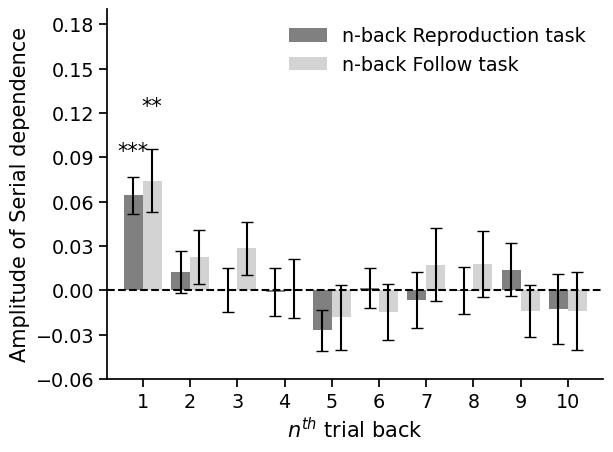

In [198]:
# plot n-back SDI for RR and JR trials
n = 10
x_rng = np.arange(1,n+1)
x_rng_nback_RR = np.arange(1,n+1)-0.2
x_rng_nback_JR = np.arange(1,n+1)+0.2
sdi_mean_nback_RR = [np.mean(sdi_RR), np.mean(sdi_RR2),np.mean(sdi_RR3),np.mean(sdi_RR4), np.mean(sdi_RR5), 
                    np.mean(sdi_RR6),np.mean(sdi_RR7), np.mean(sdi_RR8), np.mean(sdi_RR9), np.mean(sdi_RR10)]
sdi_std_nback_RR = [np.std(sdi_RR)/np.sqrt(nPar), np.std(sdi_RR2)/np.sqrt(nPar), np.std(sdi_RR3)/np.sqrt(nPar),
                    np.std(sdi_RR4)/np.sqrt(nPar), np.std(sdi_RR5)/np.sqrt(nPar), np.std(sdi_RR6)/np.sqrt(nPar),
                    np.std(sdi_RR7)/np.sqrt(nPar), np.std(sdi_RR8)/np.sqrt(nPar), np.std(sdi_RR9)/np.sqrt(nPar),
                    np.std(sdi_RR10)/np.sqrt(nPar)]
sdi_mean_nback_JR = [np.mean(sdi_FR), np.mean(sdi_FR2),np.mean(sdi_FR3),np.mean(sdi_FR4), np.mean(sdi_FR5),
                    np.mean(sdi_FR6),np.mean(sdi_FR7), np.mean(sdi_FR8), np.mean(sdi_FR9), np.mean(sdi_FR10)]
sdi_std_nback_JR = [np.std(sdi_FR)/np.sqrt(nPar), np.std(sdi_FR2)/np.sqrt(nPar), np.std(sdi_FR3)/np.sqrt(nPar),
                    np.std(sdi_FR4)/np.sqrt(nPar), np.std(sdi_FR5)/np.sqrt(nPar), np.std(sdi_FR6)/np.sqrt(nPar),
                    np.std(sdi_FR7)/np.sqrt(nPar), np.std(sdi_FR8)/np.sqrt(nPar), np.std(sdi_FR9)/np.sqrt(nPar),
                    np.std(sdi_FR10)/np.sqrt(nPar)]

fig, ax = plt.subplots()
plt.bar(x_rng_nback_RR[0:n], sdi_mean_nback_RR[0:n], color='grey', width=0.4)
plt.bar(x_rng_nback_JR[0:n], sdi_mean_nback_JR[0:n], color='lightgrey', width=0.4)
plt.errorbar(x_rng_nback_RR[0:n], sdi_mean_nback_RR[0:n], yerr=sdi_std_nback_RR[0:n],
             color='black', capsize=4, linestyle='')
plt.errorbar(x_rng_nback_JR[0:n], sdi_mean_nback_JR[0:n], yerr=sdi_std_nback_JR[0:n],
             color='black', capsize=4, linestyle='')
plt.legend(["n-back Reproduction task","n-back Follow task"], frameon=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,n+0.75)
plt.ylim(-0.04,0.19)
plt.xticks(x_rng)
plt.yticks(np.arange(-0.06, 0.19, 0.03))
plt.xlabel('$n^{th}$ trial back')
plt.ylabel('Amplitude of Serial dependence')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('***', xy=(1-0.2,0.09), zorder=10, ha='center')
ax.annotate('**', xy=(1+0.2,0.12), zorder=10, ha='center')

plt.savefig(figsDir + '/SeqEff_nBack_Rpr_preDur.png', bbox_inches='tight')

## 2. Follow task performance

### 2.1 overall follow bias

In [27]:
# overall mean bias
genFlwBias = dataFlw.groupby(['nPar']).curBias.mean().reset_index()
print(genFlwBias)
print('mean follow Bias:',genFlwBias["curBias"].mean().round(3))
print('SE of follow Bias:',genFlwBias["curBias"].sem().round(3))
# print('【The overall bias compared to zero】')
# print(pg.ttest(genFlwBias['curBias'], 0).round(3))

    nPar   curBias
0      0  0.246557
1      1 -0.053841
2      2  0.104319
3      3 -0.028314
4      4  0.291837
5      5  0.022815
6      6 -0.209878
7      7  0.145558
8      8  0.056675
9      9  0.117219
10    10  0.028311
11    11 -0.019967
12    12  0.149885
13    13  0.032108
14    14  0.165286
15    15 -0.028559
16    16  0.006482
17    17  0.214547
18    18 -0.035492
mean follow Bias: 0.063
SE of follow Bias: 0.028


mean of overall follow CV: 0.192
SE of overall follow CV: 0.009


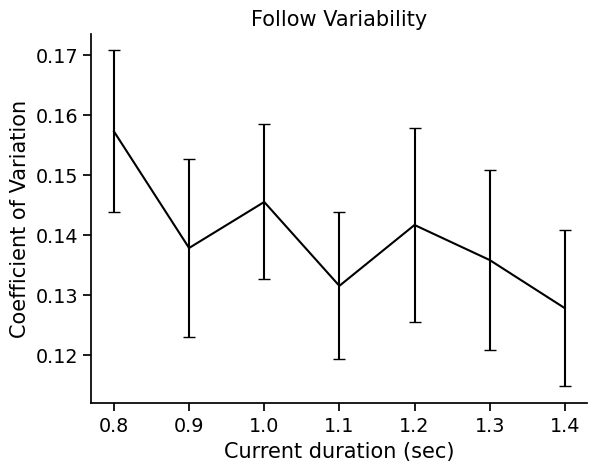

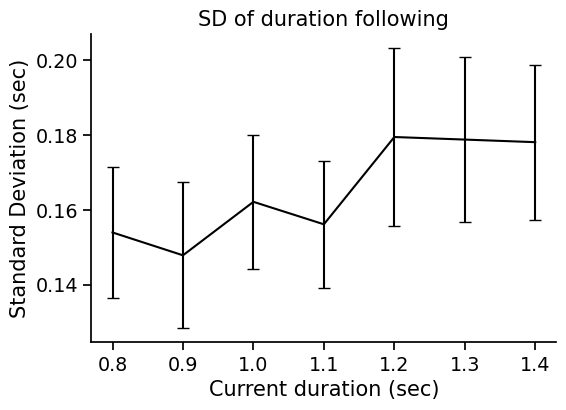

In [28]:
# overall mean follow CV
FlwCV = dataFlw.groupby(['nPar']).agg({"flw":["count","mean","std"]}).reset_index()
FlwCV.columns = ['nPar', 'count', 'mean','std']
FlwCV['cv'] = FlwCV['std']/FlwCV['mean']
# print(FlwCV)
print('mean of overall follow CV:',FlwCV["cv"].mean().round(3))
print('SE of overall follow CV:',FlwCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(FlwCV['cv'], 0).round(3))

# mean CV as a factor of duration
mFlwCVPar = dataFlw.groupby(['nPar', 'curDur']).\
    agg({"flw":["count","mean","std"]}).reset_index()
mFlwCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mFlwCVPar['cv'] = mFlwCVPar['std']/mFlwCVPar['mean']
mFlwCVAll = mFlwCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mFlwCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mFlwCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_flwcv_dur = rmANOVA_gg_Long(mFlwCVAll, 'cv', ['curDur'], 'nPar')
# print(aov_flwcv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mFlwCVAll, 
             color='black', capsize=4)
plt.xticks(mFlwCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Follow Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mFlwSDAll = mFlwCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mFlwSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mFlwSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mFlwSDAll,color='black',capsize=4)
plt.xticks(mFlwSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of duration following')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### 2.2 Central tendency effect

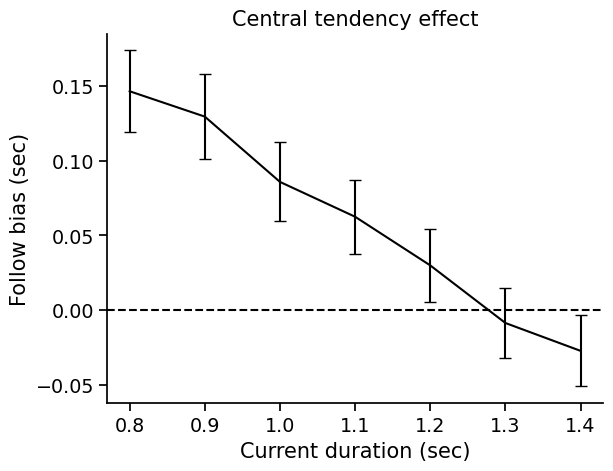

In [204]:
# Central tendency based on Reproduction Bias
mFlwBiasDurPar = dataFlw.groupby(['nPar', 'curDur']).curBias.mean().reset_index()
mFlwBiasDurAll = mFlwBiasDurPar.groupby('curDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mFlwBiasDurAll.columns = ['curDur', 'count', 'mBias','seBias']
#print(mFlwBiasDurAll)

# rmANOVA: mean bias as a factor of duration
# print('【rmANOVA: Duration main effect on mean follow bias】')
# aov_flwbias_dur = rmANOVA_gg_Long(mFlwBiasDurPar, 'curBias', ['curDur'], 'nPar')
# print(aov_flwbias_dur)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mBias', yerr='seBias', data=mFlwBiasDurAll, 
             color='black', capsize=4)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mFlwBiasDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Follow bias (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(figsDir + '/CT_FlwErr.png', bbox_inches='tight')

# # Central tendency based on Reproduction
# mFlwDurPar = dataFlw.groupby(['nPar', 'curDur']).flw.mean().reset_index()
# mFlwDurAll = mFlwDurPar.groupby('curDur').\
#     agg({"flw":["count","mean","sem"]}).reset_index()
# mFlwDurAll.columns = ['curDur', 'count', 'mRpr','seRpr']
# # print(mFlwDurAll)

# # plot central tendency
# fig, ax = plt.subplots()
# plt.errorbar(x='curDur', y='mRpr', yerr='seRpr', data=mFlwDurAll, 
#              color='black', capsize=4)
# plt.plot([0.8, 1.4], [0.8, 1.4], 'k-', lw=1, dashes=[2, 2])
# plt.xticks(mFlwDurAll.curDur)
# plt.xlabel('Current duration (sec)')
# plt.ylabel('Follow (sec)')
# plt.title('Central tendency effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # plt.savefig(figsDir + '/CT_Flw.png', bbox_inches='tight')

### 2.3 Sequential effect or Serial dependence

In [160]:
# overall Sequential effect (based on Reproduction Bias)
mFlwBiasPreDurPar = dataFlw_pre.groupby(['nPar','preDur']).curBias.mean().reset_index()
mFlwBiasPreDurAll = mFlwBiasPreDurPar.groupby('preDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mFlwBiasPreDurAll.columns = ['preDur', 'count', 'mBias','seBias']
# print(mFlwBiasPreDurAll)

# rmANOVA: mean bias as a factor of pre-duration
# print('【rmANOVA of mean follow Bias on preDuration】')
# aov_flwbias_preDur = rmANOVA_gg_Long(mFlwBiasPreDurPar, 'curBias', ['preDur'], 'nPar')
# print(aov_flwbias_preDur)

# plot sequential effect
# fig, ax = plt.subplots()
# plt.errorbar(x='preDur', y='mBias', yerr='seBias', data=mFlwBiasPreDurAll, 
#              color='black', capsize=4)
# # plt.axhline(y=0, color='black', linestyle='--')
# plt.xticks(mFlwBiasPreDurAll.preDur)
# plt.xlabel('Duration of previous n-1 trial (sec)')
# plt.ylabel('Follow bias (sec)')
# plt.title('overall Sequential effect')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FlwErr.png', bbox_inches='tight')

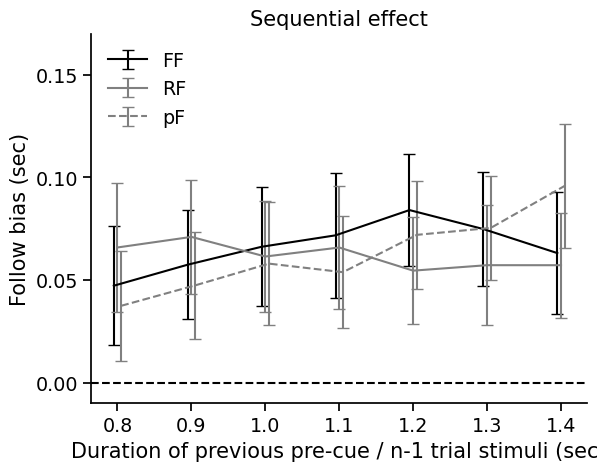

In [161]:
# Sequential effect between FF and RF
seqFlwTaskPar = dataFlw_pre.groupby(['nPar', 'preTask', 'preDur']).curBias.mean().reset_index()
seqFlwTaskAll = seqFlwTaskPar.groupby(['preTask', 'preDur']).\
    agg({"curBias":["count","mean","sem"]}).reset_index()
seqFlwTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
# print(seqFlwTaskAll)

# plot sequential effect between FF and RF
data_FF = seqFlwTaskAll.query('preTask=="following"')
data_RF = seqFlwTaskAll.query('preTask=="reproduction"')
data_pF = dataFlw.query('curTask=="following"').\
    groupby(['nPar','curPreCueDur']).curBias.mean().reset_index().\
    groupby(['curPreCueDur']).agg({"curBias":["count","mean","sem"]}).reset_index()
data_pF.columns = ['curPreCueDur', 'count', 'mBias','seBias']

fig, ax = plt.subplots()
ax.errorbar(data_FF.preDur-0.005, data_FF.mBias, data_FF.seBias, 
             color='black', capsize=4, label='FF')
ax.errorbar(data_RF.preDur, data_RF.mBias, data_RF.seBias, 
             color='grey', capsize=4, label='RF')
ax.errorbar(data_pF.curPreCueDur+0.005, data_pF.mBias, data_pF.seBias, 
             color='grey', capsize=4, label='pF', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_FF.preDur)
plt.yticks(np.arange(-0.05, 0.18, 0.05))
plt.ylim(-0.01, 0.17)
plt.xlabel('Duration of previous pre-cue / n-1 trial stimuli (sec)')
plt.ylabel('Follow bias (sec)')
plt.title('Sequential effect')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(figsDir + '/SeqEff_FFvsRF.png', bbox_inches='tight')

mean SDI slope in FF:  0.047
std SDI slope in FF:  0.018
              T  dof alternative   p-val         CI95%  cohen-d   BF10  \
T-test  2.53652   21   two-sided  0.0192  [0.01, 0.09]  0.54079  2.898   

          power  
T-test  0.67701  
mean SDI slope in RF:  -0.019
std SDI slope in RF:  0.021
              T  dof alternative   p-val          CI95%  cohen-d  BF10  \
T-test -0.90043   21   two-sided  0.3781  [-0.06, 0.03]  0.19197  0.32   

          power  
T-test  0.13803  
【Comparison of SDI in FF vs RF】
              T  dof alternative    p-val         CI95%  cohen-d   BF10  \
T-test  2.25661   21   two-sided  0.03482  [0.01, 0.13]  0.70815  1.789   

          power  
T-test  0.88615  


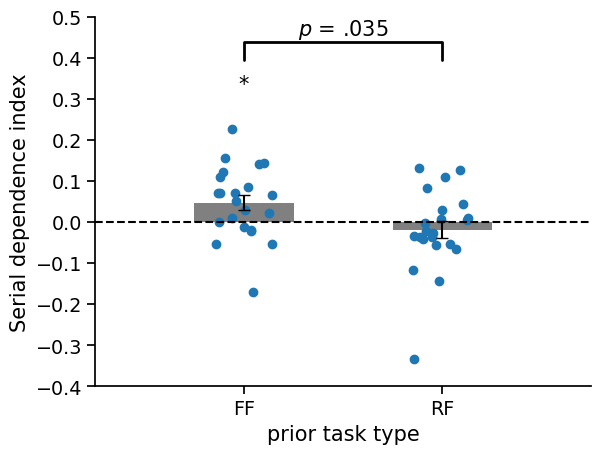

In [203]:
# calculate SDI and plot
dataFF = dataFlw_pre.query('preTask=="following"')
dataRF = dataFlw_pre.query('preTask=="reproduction"')

slope_1, slope_FF_sdi, int_1 = LM_2F(dataFF, ['curDur','preDur','curBias'])
slope_1, slope_RF_sdi, int_1 = LM_2F(dataRF, ['curDur','preDur','curBias'])

print("mean SDI slope in FF: ", slope_FF_sdi.mean().round(3))
print("std SDI slope in FF: ", round(slope_FF_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FF_sdi, 0).round(5))
print("mean SDI slope in RF: ", slope_RF_sdi.mean().round(3))
print("std SDI slope in RF: ", round(slope_RF_sdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RF_sdi, 0).round(5))
print("【Comparison of SDI in FF vs RF】")
print(pg.ttest(slope_FF_sdi, slope_RF_sdi, paired=True).round(5))

# Custom function to draw the diff bars
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':30,'shrinkB':30,'linewidth':2}
    ax.annotate(text, xy=(X[i]+dx*3/11,y*1.55), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi)],
             yerr=[np.std(slope_FF_sdi)/np.sqrt(nPar), np.std(slope_RF_sdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2], \
            [slope_FF_sdi, slope_RF_sdi])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['FF', 'RF'])
plt.yticks(np.arange(-0.4, 0.52, 0.1))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('*', xy=(1,0.32), zorder=10, ha='center')
# ax.annotate('**', xy=(2,0.32), zorder=10, ha='center')
label_diff(0,1,'$\mathit{p}$ = .035', np.arange(1,3), [np.mean(slope_FF_sdi)+0.22, np.mean(slope_RF_sdi)+0.22])

plt.savefig(figsDir + '/SeqEff_FFvsRF_SDI.png', bbox_inches='tight')

mean SDI slope in pre-cue Gabor:  0.085
std SDI slope in pre-cue Gabor:  0.012
             T  dof alternative  p-val         CI95%  cohen-d       BF10  \
T-test  7.0319   19   two-sided    0.0  [0.06, 0.11]  1.57238  1.675e+04   

        power  
T-test    1.0  


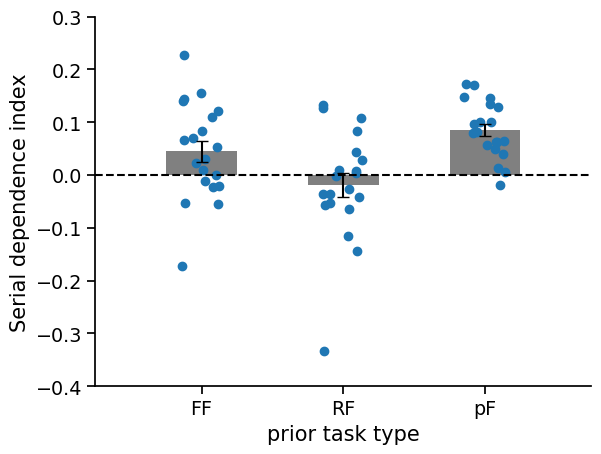

In [176]:
# calculate the serial dependence of pre-cue stimuli in follow condition
slp_1, slope_csdi, int_1 = LM_2F(dataFlw.query('curTask=="following"'), ['curDur','curPreCueDur','curBias'])
print("mean SDI slope in pre-cue Gabor: ", slope_csdi.mean().round(3))
print("std SDI slope in pre-cue Gabor: ", round(slope_csdi.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_csdi, 0).round(5))

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,4), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi), np.mean(slope_csdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,4), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi), np.mean(slope_csdi)],
             yerr=[np.std(slope_FF_sdi)/np.sqrt(nPar), np.std(slope_RF_sdi)/np.sqrt(nPar), np.std(slope_csdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2, (np.random.random(nPar)-0.5)*0.3+3], \
            [slope_FF_sdi, slope_RF_sdi, slope_csdi])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,3.75)
plt.xticks(np.arange(1,4), ['FF', 'RF', 'pF'])
plt.yticks(np.arange(-0.4, 0.32, 0.1))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<Figure size 640x480 with 0 Axes>

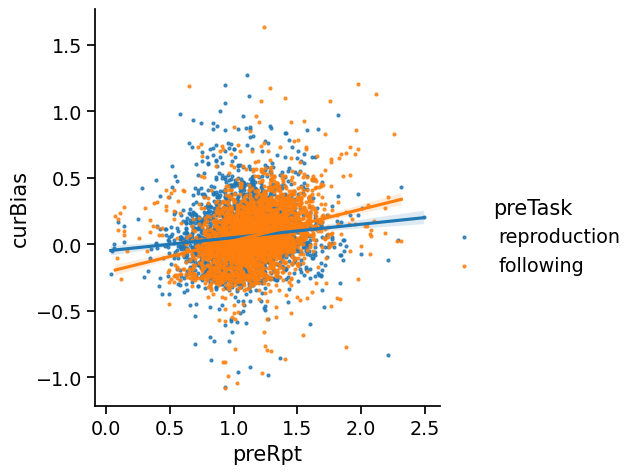

In [205]:
plt.figure()
sns.lmplot(data=dataFlw_pre.query('preRpt<3'), x="preRpt", y="curBias", hue='preTask', scatter_kws={"s": 4}) # 
plt.savefig(figsDir + '/SeqEff_FFvsRF_DCI_scatter.png', bbox_inches='tight')

mean SDI slope in FF:  0.097
std SDI slope in FF:  0.018
              T  dof alternative    p-val         CI95%  cohen-d     BF10  \
T-test  5.21485   21   two-sided  0.00004  [0.06, 0.14]  1.11181  684.166   

          power  
T-test  0.99867  
mean SDI slope in RF:  0.059
std SDI slope in RF:  0.023
              T  dof alternative    p-val         CI95%  cohen-d  BF10  \
T-test  2.49028   21   two-sided  0.02122  [0.01, 0.11]  0.53093  2.67   

          power  
T-test  0.66105  
【Comparison of SDI in FF vs RF】
              T  dof alternative   p-val          CI95%  cohen-d   BF10  \
T-test  1.42869   21   two-sided  0.1678  [-0.02, 0.09]   0.3811  0.542   

         power  
T-test  0.3998  


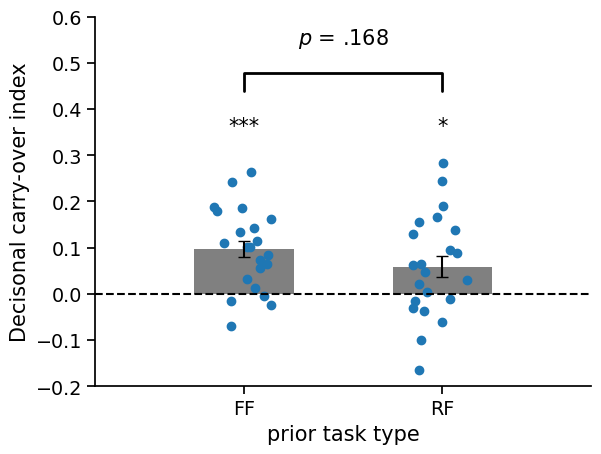

In [208]:
# calculate Decisional carry-over index (DCI) and plot
slope_1, slope_FF_dci, int_1 = LM_2F(dataFF, ['curDur','preRpt','curBias'])
print("mean SDI slope in FF: ", slope_FF_dci.mean().round(3))
print("std SDI slope in FF: ", round(slope_FF_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_FF_dci, 0).round(5))

slope_1, slope_RF_dci, int_1 = LM_2F(dataRF, ['curDur','preRpt','curBias'])
print("mean SDI slope in RF: ", slope_RF_dci.mean().round(3))
print("std SDI slope in RF: ", round(slope_RF_dci.std()/np.sqrt(nPar),3))
print(pg.ttest(slope_RF_dci, 0).round(5))

print("【Comparison of SDI in FF vs RF】")
print(pg.ttest(slope_FF_dci, slope_RF_dci, paired=True).round(5))

# Custom function to draw the diff bars
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':30,'shrinkB':30,'linewidth':2}
    ax.annotate(text, xy=(X[i]+dx*3/11,y*1.55), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_FF_dci), np.mean(slope_RF_dci)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_FF_dci), np.mean(slope_RF_dci)],
             yerr=[np.std(slope_FF_dci)/np.sqrt(nPar), np.std(slope_RF_dci)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.scatter([(np.random.random(nPar)-0.5)*0.3+1, (np.random.random(nPar)-0.5)*0.3+2],\
            [slope_FF_dci, slope_RF_dci])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['FF', 'RF'])
plt.yticks(np.arange(-0.2, 0.61, 0.1))
plt.xlabel('prior task type')
plt.ylabel('Decisonal carry-over index')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('***', xy=(1,0.35), zorder=10, ha='center')
ax.annotate('*', xy=(2,0.35), zorder=10, ha='center')
label_diff(0,1,'$\mathit{p}$ = .168', np.arange(1,3), [np.mean(slope_FF_dci)+0.22, np.mean(slope_RF_dci)+0.22])

plt.savefig(figsDir + '/SeqEff_FFvsRF_DCI.png', bbox_inches='tight')

### 2.4 follow latency (onset- and offset-based)

In [297]:
dataValid.query('flwAfterOff==False & flwOffLtc <0')

,nPar,nB,nT,curTask,curDur,rpr,flw,curPreCueDur,curRpt,preTask,preDur,preRpt,prePreCueDur,flwOnLtc,flwOffLtc,flwAfterOff,rprOnLtc,valid
1,17,1,2,following,1.3,0.0,1.434809,0.8,1.434809,reproduction,1.0,0.811564,NaN,-0.141013,-0.011680,False,NaN,1
8,17,1,9,following,1.2,0.0,1.481868,1.3,1.481868,reproduction,0.8,0.870275,NaN,-0.293925,-0.011678,False,NaN,1
96,17,2,41,following,1.3,0.0,1.293639,1.4,1.293639,reproduction,1.2,1.317255,NaN,0.000144,-0.011692,False,NaN,1
392,17,8,1,following,1.3,0.0,1.305423,0.8,1.305423,NaN,NaN,NaN,NaN,-0.011638,-0.011691,False,NaN,1
402,17,8,11,following,1.4,0.0,1.599448,1.0,1.599448,reproduction,1.4,1.176149,NaN,-0.211559,-0.011689,False,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12288,19,10,25,following,1.4,0.0,1.305413,0.9,1.305413,reproduction,1.1,1.082049,NaN,0.082471,-0.011694,False,NaN,1
12297,19,10,34,following,1.1,0.0,0.976194,0.8,0.976194,following,1.0,1.070235,1.0,0.117738,-0.011621,False,NaN,1
12310,19,10,47,following,1.3,0.0,1.340703,1.0,1.340703,following,1.0,1.046725,1.1,-0.046903,-0.011686,False,NaN,1
12313,19,10,50,following,1.3,0.0,1.223089,1.4,1.223089,reproduction,0.8,0.717476,NaN,0.070700,-0.011700,False,NaN,1


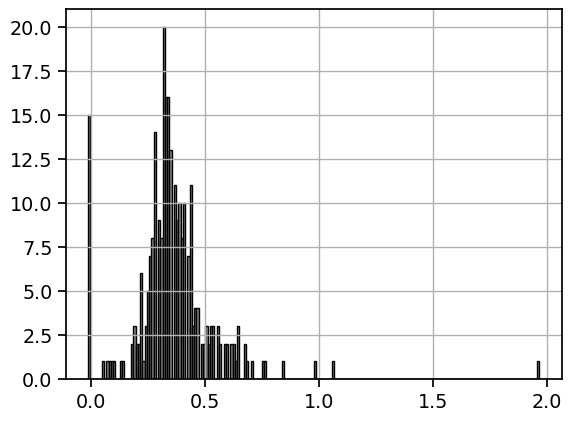

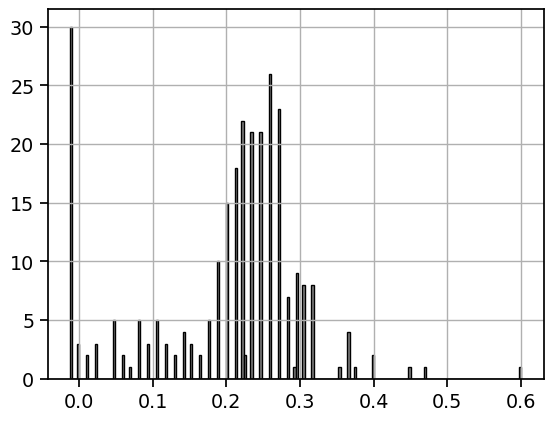

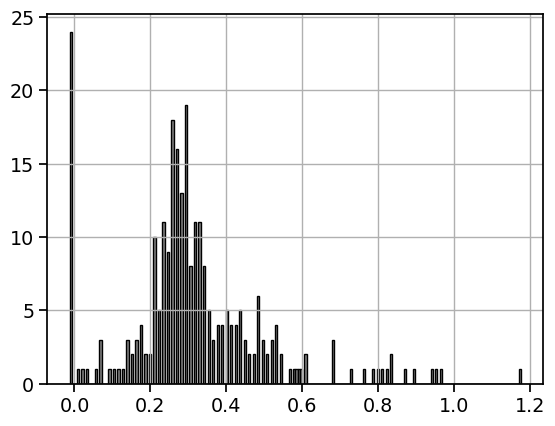

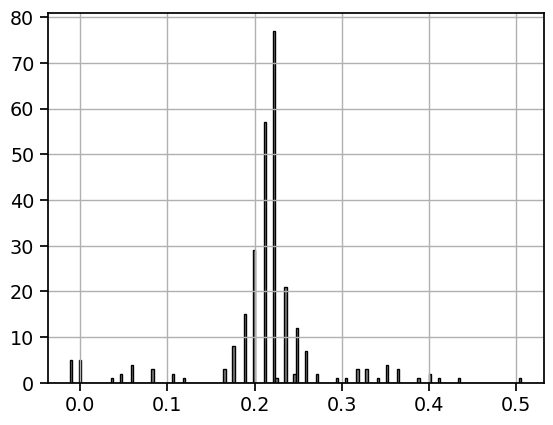

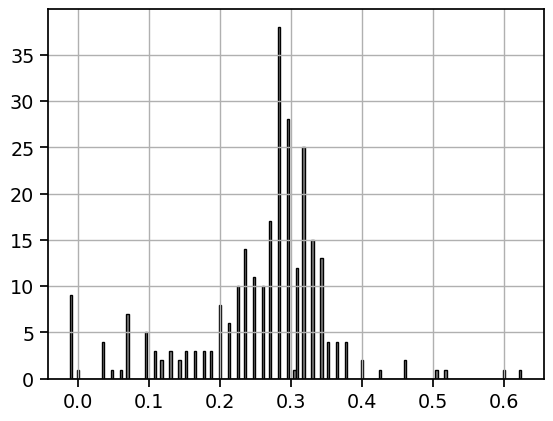

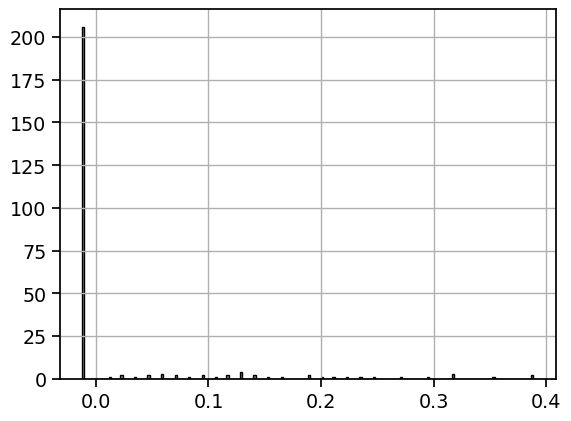

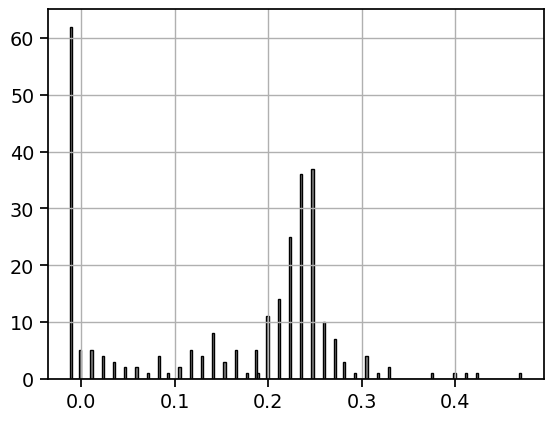

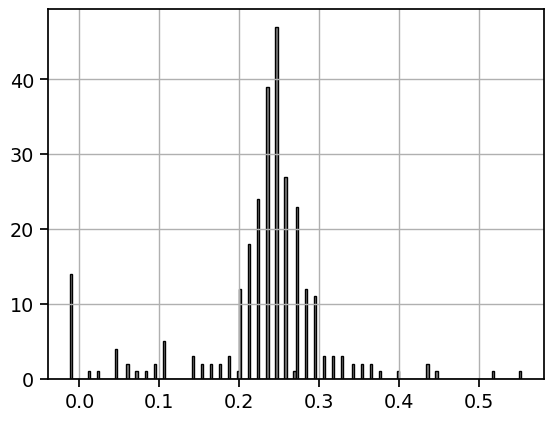

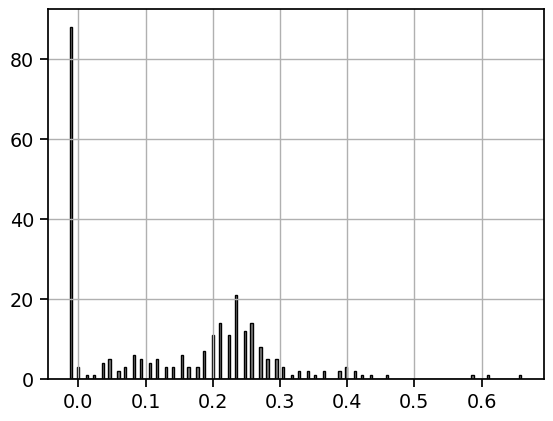

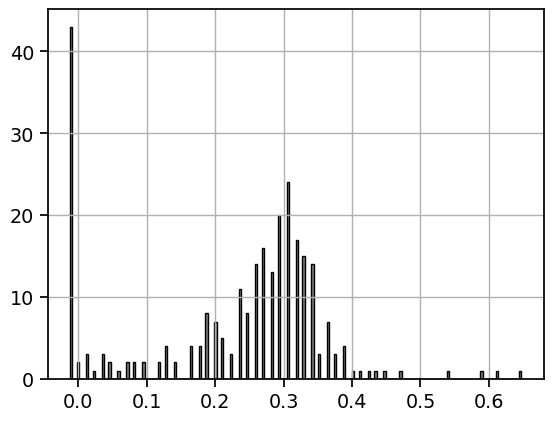

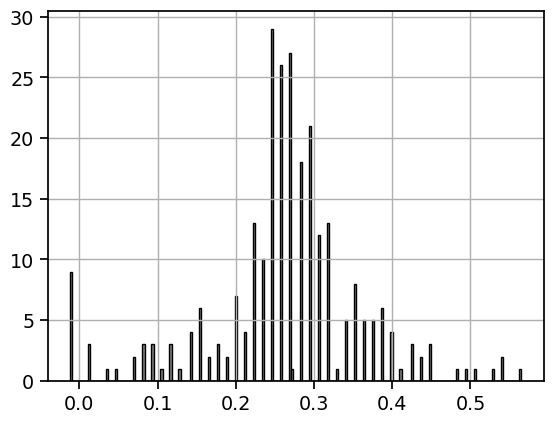

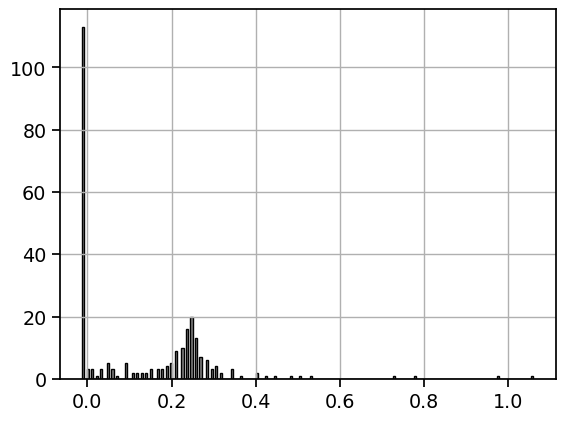

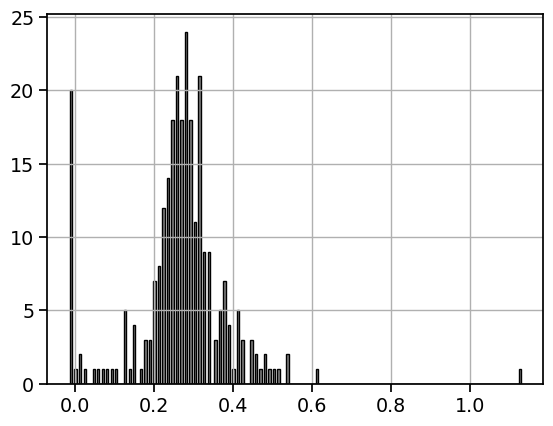

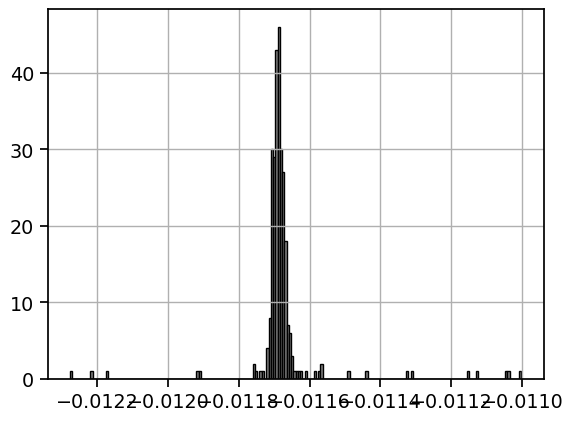

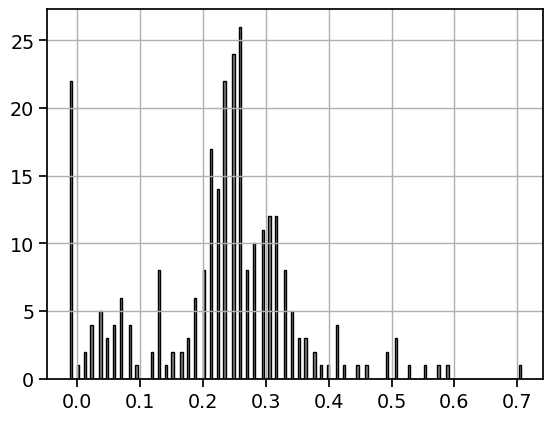

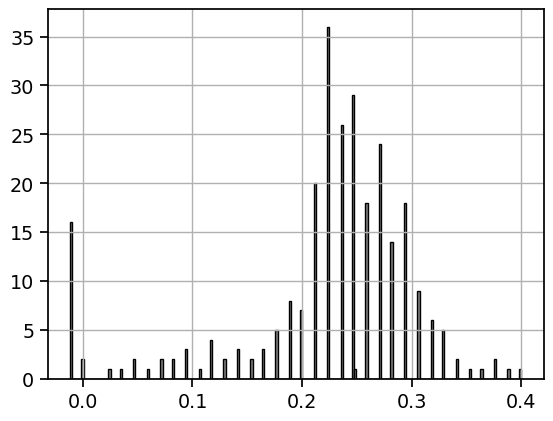

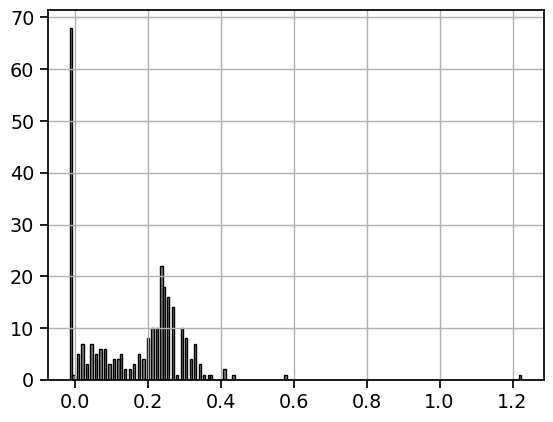

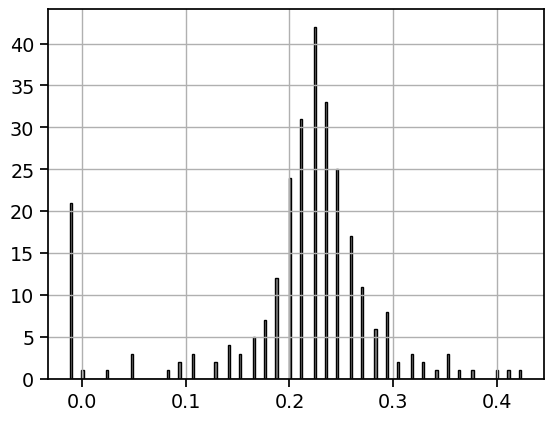

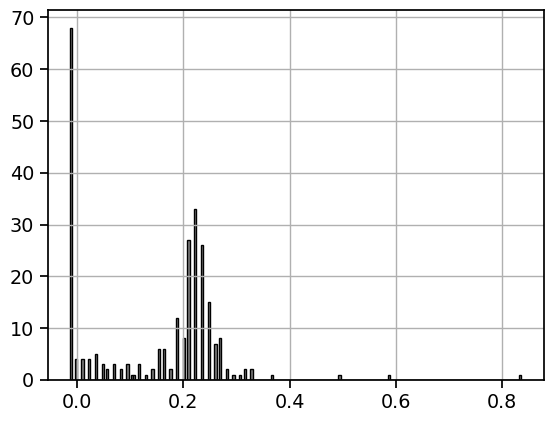

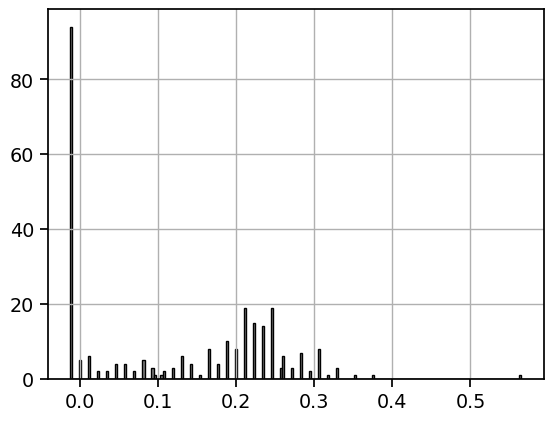

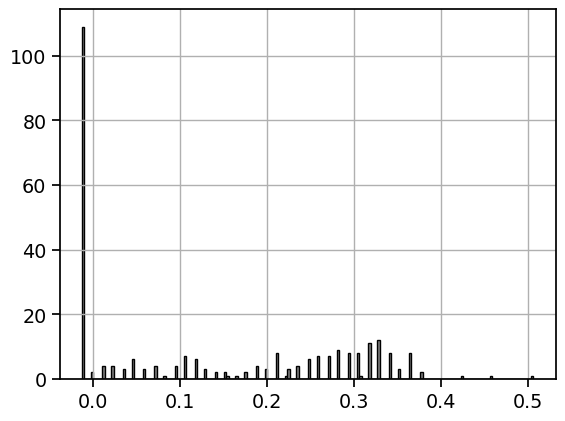

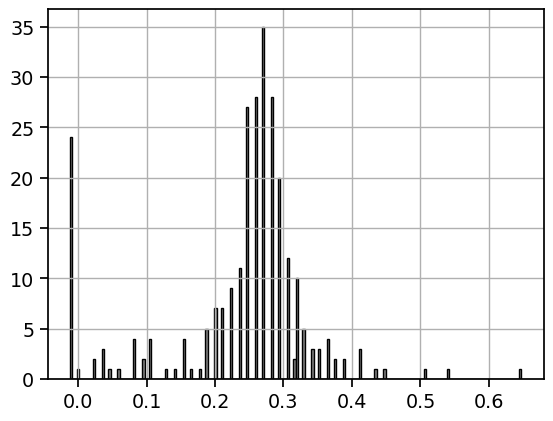

In [298]:
# # delay of the psychopy timing system 
# print('rprOnLtc range:[',dataValid['rprOnLtc'].min(),',',dataValid['rprOnLtc'].max(),']')
# abs(dataValid['rprOnLtc']*1000).hist(bins=30, color='grey', edgecolor='black') # & rpr < 0.9
# plt.show()

# print('flwOnLtc range:[',dataFlw['flwOnLtc'].min(),',',dataFlw['flwOnLtc'].max(),']')
# print('flwOnLtc range:[',dataFlw.query('flwAfterOff==False')['flwOnLtc'].min(),',',dataFlw.query('flwAfterOff==False')['flwOnLtc'].max(),']')
# dataFlw.query('flwAfterOff==False')['flwOnLtc'].hist(bins=20, color='grey', edgecolor='black') # & rpr < 0.9
# plt.show()

# print('flwOffLtc range:[',dataFlw.query('flwAfterOff==False')['flwOffLtc'].min(),',',dataFlw.query('flwAfterOff==False')['flwOffLtc'].max(),']')
# dataFlw.query('flwAfterOff==False & flwOffLtc <1.4')['flwOffLtc'].hist(bins=200, color='grey', edgecolor='black') # & rpr < 0.9
# plt.show()

for i in range(nPar):
    parList = data.nPar.unique()
    nPar = parList.size
    iPar = parList[i]
    dataFlw.query('flwAfterOff==False & nPar==@iPar')['flwOffLtc'].hist(bins=200, color='grey', edgecolor='black') # & rpr < 0.9
    plt.show()


In [280]:
# overall follow onset latency
genFlwOnLtc = dataFlw.groupby(['nPar']).flwOnLtc.mean().reset_index()
# print(genFlwOnLtc)
print('mean follow onset latency:',genFlwOnLtc["flwOnLtc"].mean().round(3))
print('SE of follow onset latency:',genFlwOnLtc["flwOnLtc"].sem().round(3))

genFlwOffLtc = dataFlw.groupby(['nPar']).flwOffLtc.mean().reset_index()
# print(genFlwOffLtc)
print('mean follow offset latency:',genFlwOffLtc["flwOffLtc"].mean().round(3))
print('SE of follow offset latency:',genFlwOffLtc["flwOffLtc"].sem().round(3))

mean follow onset latency: 0.164
SE of follow onset latency: 0.02
mean follow offset latency: 0.222
SE of follow offset latency: 0.021


##### follow onset latency

mean of overall CV of follow onset latency: 1.961
SE of overall CV of follow onset latency: 1.094


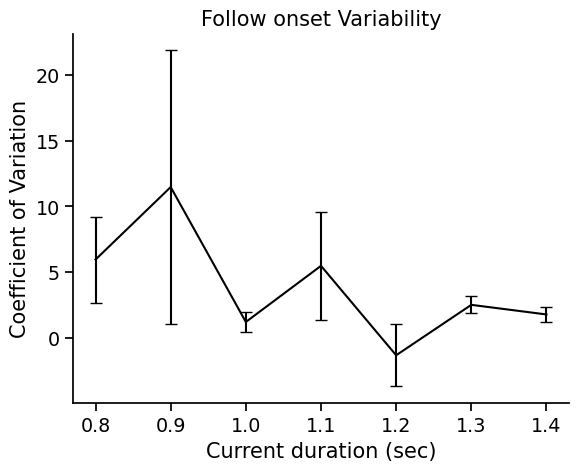

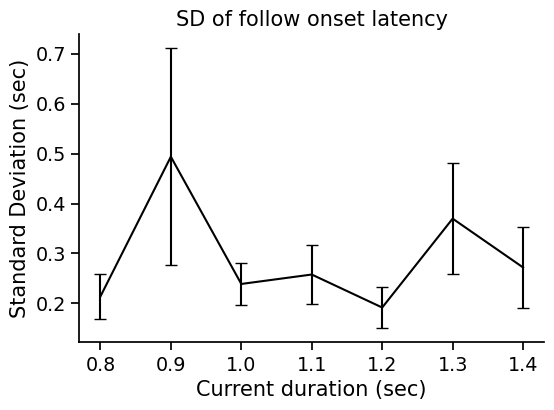

In [269]:
# overall CV for follow onset latency
FlwOnLtcCV = dataFlw.groupby(['nPar']).agg({"flwOnLtc":["count","mean","std"]}).reset_index()
FlwOnLtcCV.columns = ['nPar', 'count', 'mean','std']
FlwOnLtcCV['cv'] = FlwOnLtcCV['std']/FlwOnLtcCV['mean']
# print(FlwOnLtcCV)
print('mean of overall CV of follow onset latency:',FlwOnLtcCV["cv"].mean().round(3))
print('SE of overall CV of follow onset latency:',FlwOnLtcCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(FlwOnLtcCV['cv'], 0).round(3))

# mean CV as a factor of duration
mFlwOnLtcCVPar = dataFlw.groupby(['nPar', 'curDur']).\
    agg({"flwOnLtc":["count","mean","std"]}).reset_index()
mFlwOnLtcCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mFlwOnLtcCVPar['cv'] = mFlwOnLtcCVPar['std']/mFlwOnLtcCVPar['mean']
mFlwOnLtcCVAll = mFlwOnLtcCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mFlwOnLtcCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mFlwOnLtcCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_flwOnLtccv_dur = rmANOVA_gg_Long(mFlwOnLtcCVAll, 'cv', ['curDur'], 'nPar')
# print(aov_flwOnLtccv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mFlwOnLtcCVAll, 
             color='black', capsize=4)
plt.xticks(mFlwOnLtcCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Follow onset Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mFlwOnLtcSDAll = mFlwOnLtcCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mFlwOnLtcSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mFlwSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mFlwOnLtcSDAll,color='black',capsize=4)
plt.xticks(mFlwOnLtcSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of follow onset latency')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

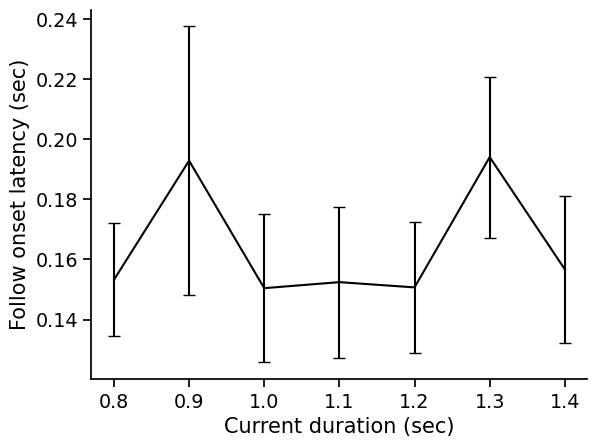

In [273]:
# Central tendency based on follow onset latency
mFlwOnLtcDurPar = dataFlw.groupby(['nPar', 'curDur']).flwOnLtc.mean().reset_index()
mFlwOnLtcDurAll = mFlwOnLtcDurPar.groupby('curDur').\
    agg({"flwOnLtc":["count","mean","sem"]}).reset_index()
mFlwOnLtcDurAll.columns = ['curDur', 'count', 'mLtc','seLtc']
mFlwOnLtcDurAll

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mLtc', yerr='seLtc', data=mFlwOnLtcDurAll, 
             color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mFlwOnLtcDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Follow onset latency (sec)')
plt.title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig(figsDir + '/CT_FlwErr.png', bbox_inches='tight')


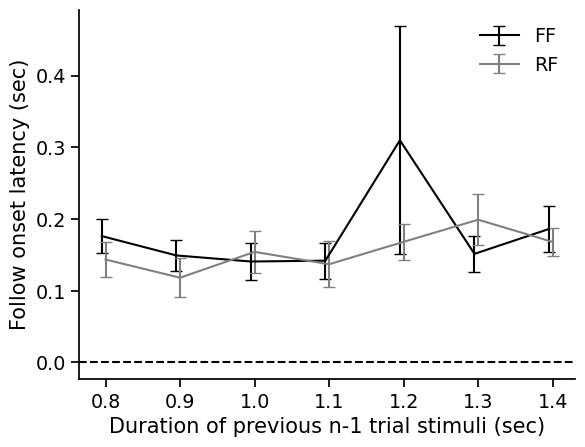

In [272]:
# Sequential effect between FF and RF
seqFlwOnLtcTaskPar = dataFlw_pre.groupby(['nPar', 'preTask', 'preDur']).flwOnLtc.mean().reset_index()
seqFlwOnLtcTaskAll = seqFlwOnLtcTaskPar.groupby(['preTask', 'preDur']).\
    agg({"flwOnLtc":["count","mean","sem"]}).reset_index()
seqFlwOnLtcTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
# print(seqFlwOnLtcTaskAll)

# plot sequential effect between FF and RF
data_FF = seqFlwOnLtcTaskAll.query('preTask=="following"')
data_RF = seqFlwOnLtcTaskAll.query('preTask=="reproduction"')

fig, ax = plt.subplots()
ax.errorbar(data_FF.preDur-0.005, data_FF.mBias, data_FF.seBias, 
             color='black', capsize=4, label='FF')
ax.errorbar(data_RF.preDur, data_RF.mBias, data_RF.seBias, 
             color='grey', capsize=4, label='RF')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_FF.preDur)
# plt.yticks(np.arange(-0.05, 0.18, 0.05))
# plt.ylim(-0.01, 0.17)
plt.xlabel('Duration of previous n-1 trial stimuli (sec)')
plt.ylabel('Follow onset latency (sec)')
plt.title('')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FFvsRF.png', bbox_inches='tight')

##### follow offset latency

mean of overall CV of follow offset latency: 1.21
SE of overall CV of follow offset latency: 0.216


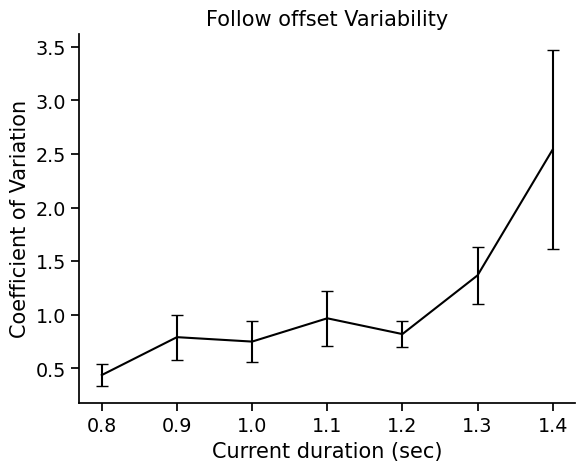

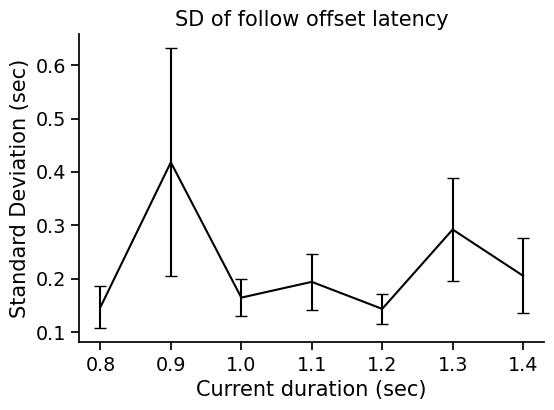

In [291]:
# overall CV for follow onset latency
FlwOffLtcCV = dataFlw.groupby(['nPar']).agg({"flwOffLtc":["count","mean","std"]}).reset_index()
FlwOffLtcCV.columns = ['nPar', 'count', 'mean','std']
FlwOffLtcCV['cv'] = FlwOffLtcCV['std']/FlwOffLtcCV['mean']
# print(FlwOffLtcCV)
print('mean of overall CV of follow offset latency:',FlwOffLtcCV["cv"].mean().round(3))
print('SE of overall CV of follow offset latency:',FlwOffLtcCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(FlwOffLtcCV['cv'], 0).round(3))

# mean CV as a factor of duration
mFlwOffLtcCVPar = dataFlw.groupby(['nPar', 'curDur']).\
    agg({"flwOffLtc":["count","mean","std"]}).reset_index()
mFlwOffLtcCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mFlwOffLtcCVPar['cv'] = mFlwOffLtcCVPar['std']/mFlwOffLtcCVPar['mean']
mFlwOffLtcCVAll = mFlwOffLtcCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mFlwOffLtcCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mFlwOffLtcCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_flwOffLtccv_dur = rmANOVA_gg_Long(mFlwOffLtcCVAll, 'cv', ['curDur'], 'nPar')
# print(aov_flwOffLtccv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mFlwOffLtcCVAll, 
             color='black', capsize=4)
plt.xticks(mFlwOffLtcCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Follow offset Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mFlwOffLtcSDAll = mFlwOffLtcCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mFlwOffLtcSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mFlwSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mFlwOffLtcSDAll,color='black',capsize=4)
plt.xticks(mFlwOffLtcSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of follow offset latency')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

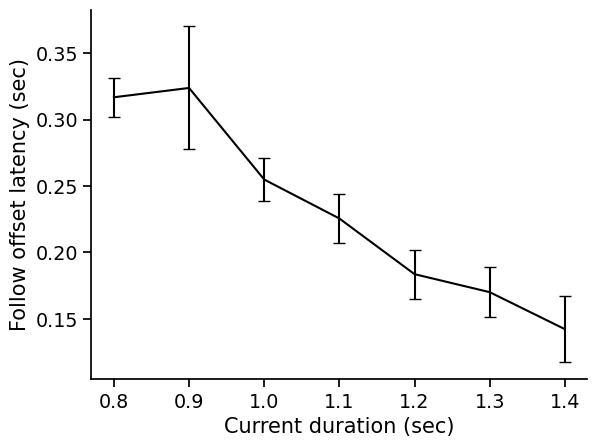

In [309]:
# Central tendency based on follow onset latency
mFlwOffLtcDurPar = dataFlw.query('nPar != 6 & nPar != 14').groupby(['nPar', 'curDur']).flwOffLtc.mean().reset_index()
mFlwOffLtcDurAll = mFlwOffLtcDurPar.groupby('curDur').\
    agg({"flwOffLtc":["count","mean","sem"]}).reset_index()
mFlwOffLtcDurAll.columns = ['curDur', 'count', 'mLtc','seLtc']
mFlwOffLtcDurAll

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mLtc', yerr='seLtc', data=mFlwOffLtcDurAll, 
             color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mFlwOffLtcDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Follow offset latency (sec)')
plt.title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig(figsDir + '/CT_FlwErr.png', bbox_inches='tight')


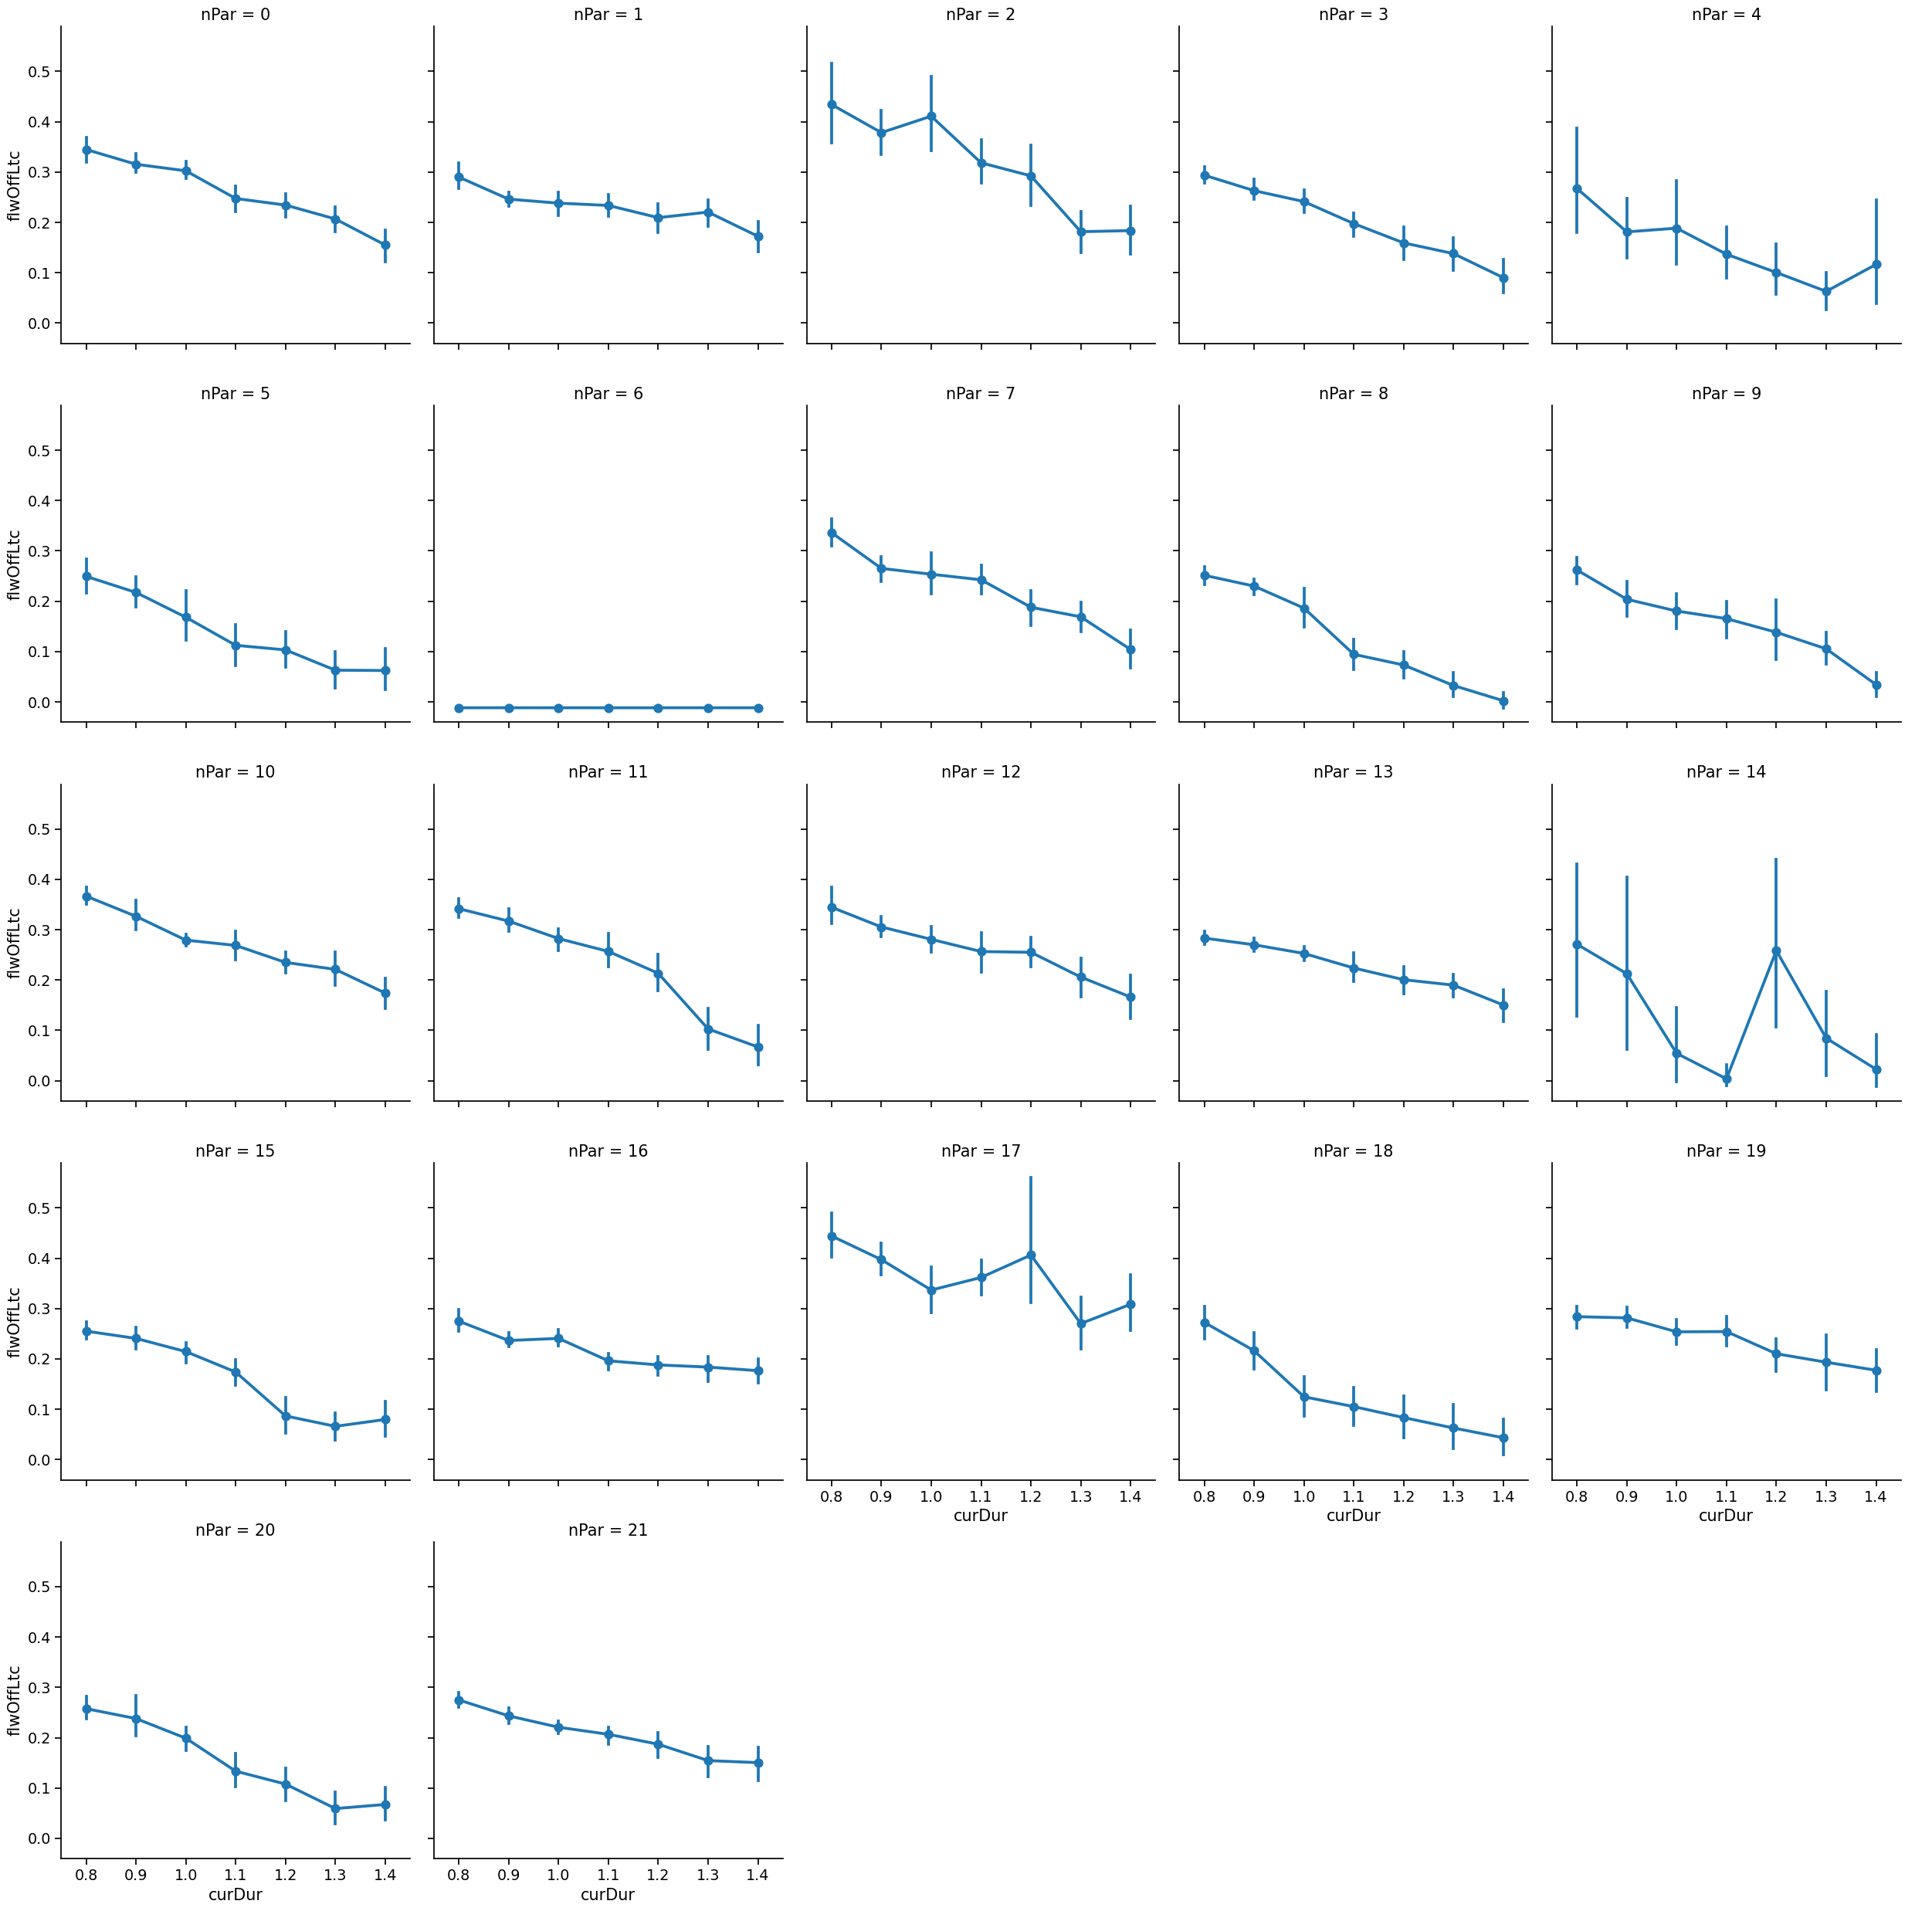

In [308]:
# quickly visualize the individual data
sns.catplot(data = dataFlw.query('flwOffLtc < 2'), kind = 'point', 
            x = 'curDur', y = 'flwOffLtc', col = 'nPar', col_wrap = 5)

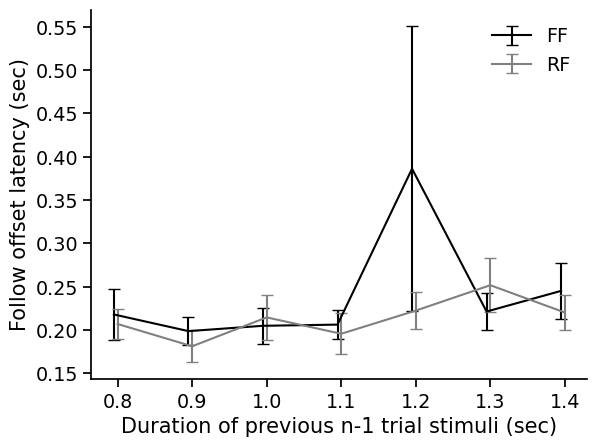

In [294]:
# Sequential effect between FF and RF
seqFlwOffLtcTaskPar = dataFlw_pre.groupby(['nPar', 'preTask', 'preDur']).flwOffLtc.mean().reset_index()
seqFlwOffLtcTaskAll = seqFlwOffLtcTaskPar.groupby(['preTask', 'preDur']).\
    agg({"flwOffLtc":["count","mean","sem"]}).reset_index()
seqFlwOffLtcTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
# print(seqFlwOffLtcTaskAll)

# plot sequential effect between FF and RF
data_FF = seqFlwOffLtcTaskAll.query('preTask=="following"')
data_RF = seqFlwOffLtcTaskAll.query('preTask=="reproduction"')

fig, ax = plt.subplots()
ax.errorbar(data_FF.preDur-0.005, data_FF.mBias, data_FF.seBias, 
             color='black', capsize=4, label='FF')
ax.errorbar(data_RF.preDur, data_RF.mBias, data_RF.seBias, 
             color='grey', capsize=4, label='RF')
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_FF.preDur)
# plt.yticks(np.arange(-0.05, 0.18, 0.05))
# plt.ylim(-0.01, 0.17)
plt.xlabel('Duration of previous n-1 trial stimuli (sec)')
plt.ylabel('Follow offset latency (sec)')
plt.title('')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FFvsRF.png', bbox_inches='tight')